Features shape: torch.Size([100, 4])
Adjacency matrix shape: torch.Size([100, 100])
Epoch [1/1000], Step [1/48], D Loss: 40.529170989990234, G Loss: 5.349725723266602
Epoch [1/1000], Step [2/48], D Loss: 40.31145477294922, G Loss: 5.339703559875488
Epoch [1/1000], Step [3/48], D Loss: 40.10405731201172, G Loss: 5.323495388031006
Epoch [1/1000], Step [4/48], D Loss: 39.910186767578125, G Loss: 5.312867641448975
Epoch [1/1000], Step [5/48], D Loss: 39.725311279296875, G Loss: 5.295410633087158
Epoch [1/1000], Step [6/48], D Loss: 39.544647216796875, G Loss: 5.2780914306640625
Epoch [1/1000], Step [7/48], D Loss: 39.3697509765625, G Loss: 5.263124465942383
Epoch [1/1000], Step [8/48], D Loss: 39.20994567871094, G Loss: 5.245045185089111
Epoch [1/1000], Step [9/48], D Loss: 39.05144500732422, G Loss: 5.22703742980957
Epoch [1/1000], Step [10/48], D Loss: 38.898590087890625, G Loss: 5.214702606201172
Epoch [1/1000], Step [11/48], D Loss: 38.75468826293945, G Loss: 5.193263530731201
Epoch [1

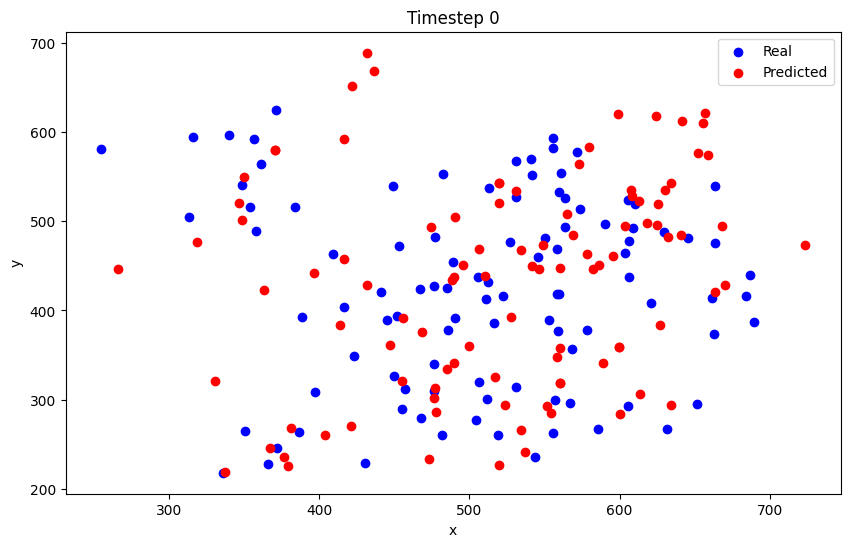

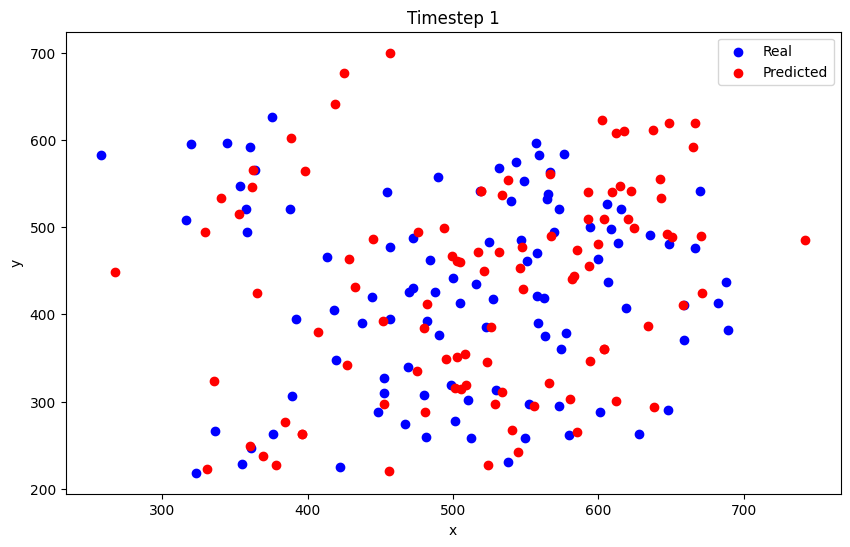

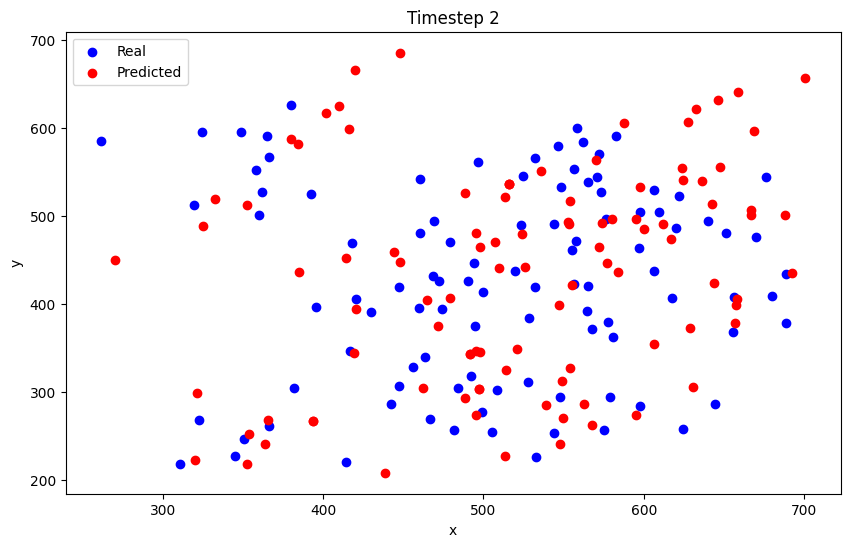

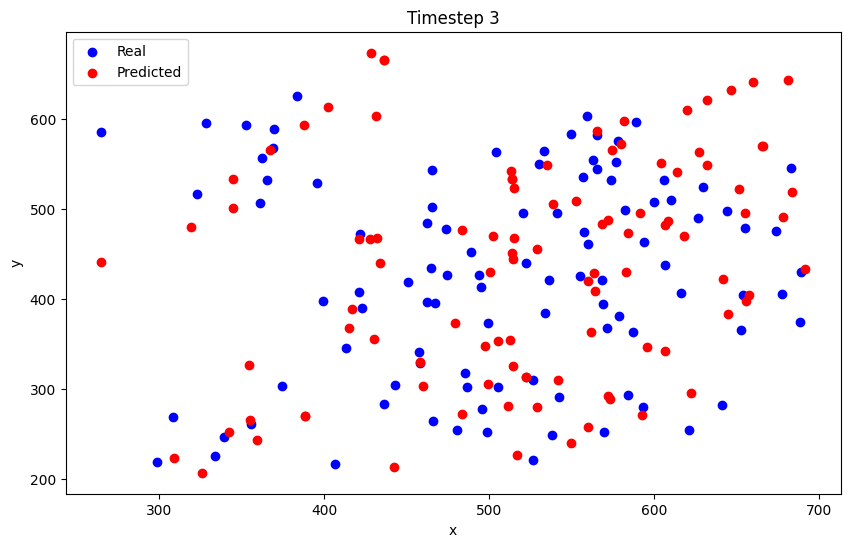

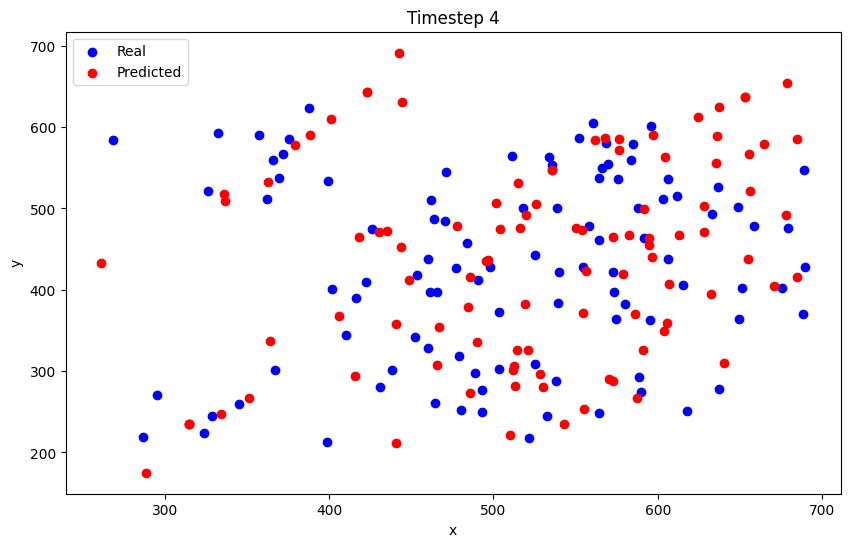

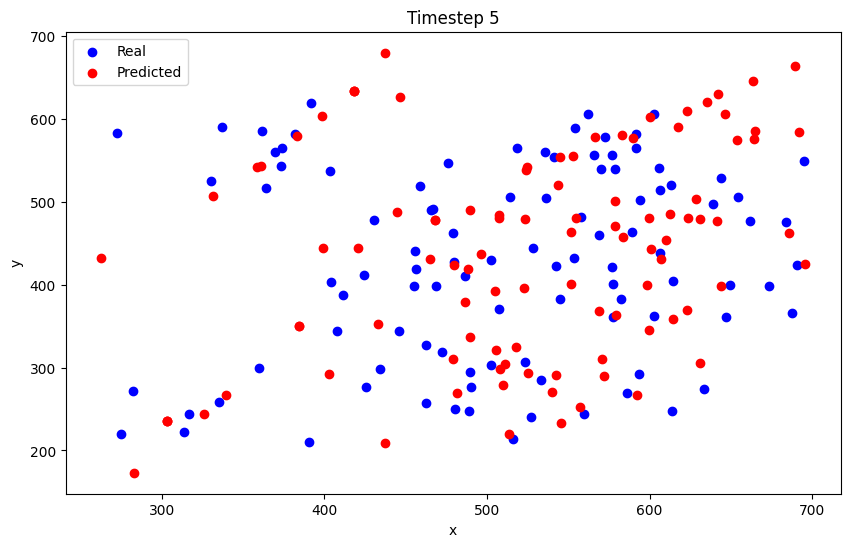

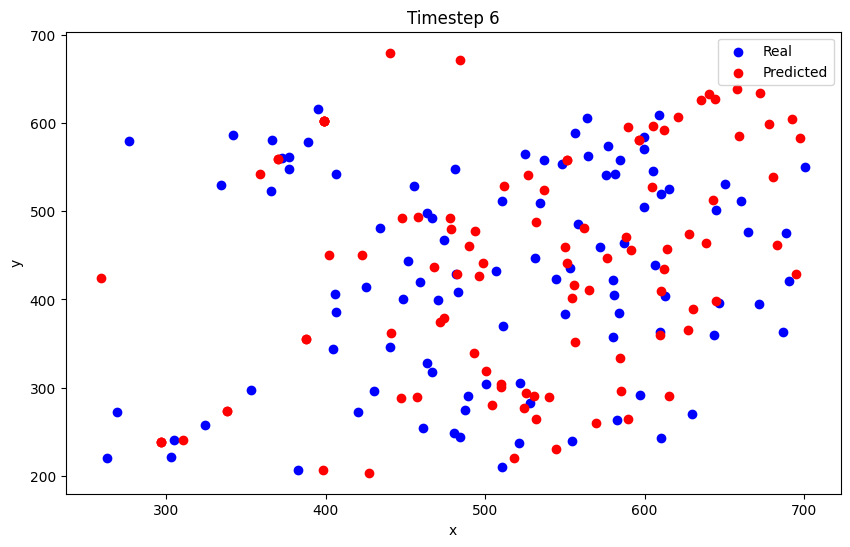

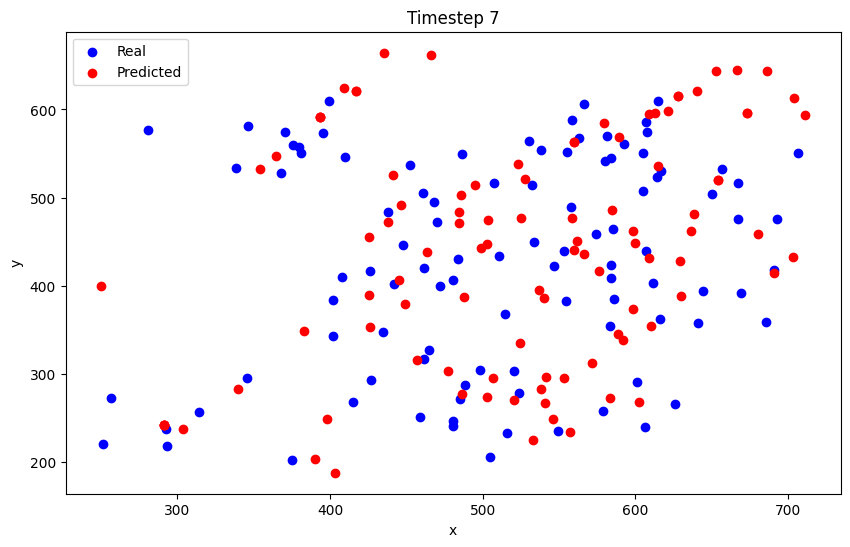

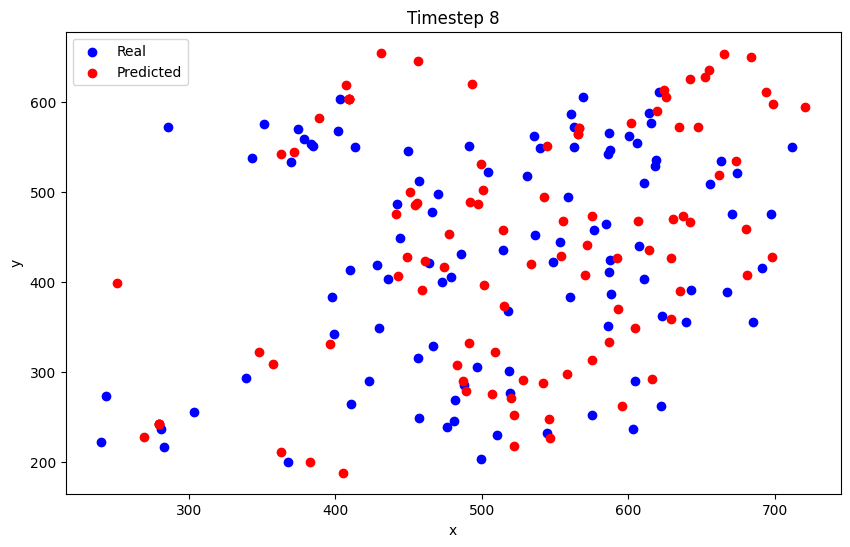

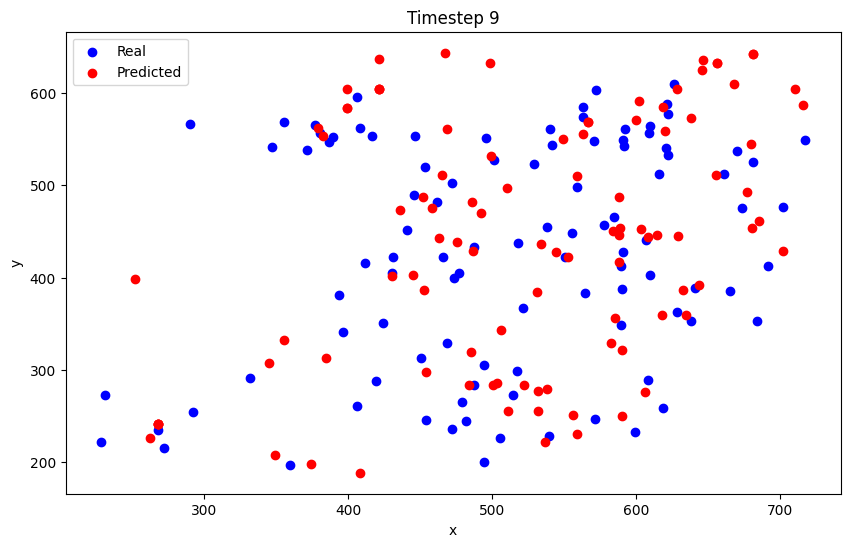

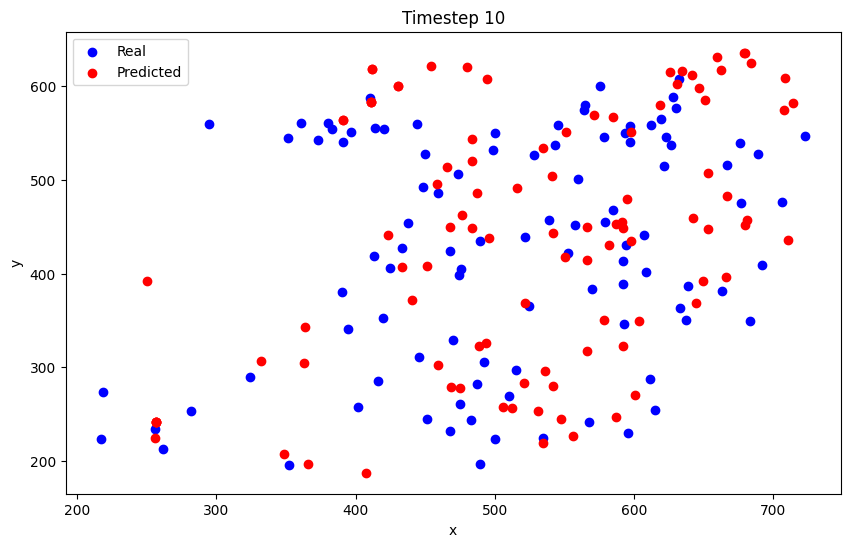

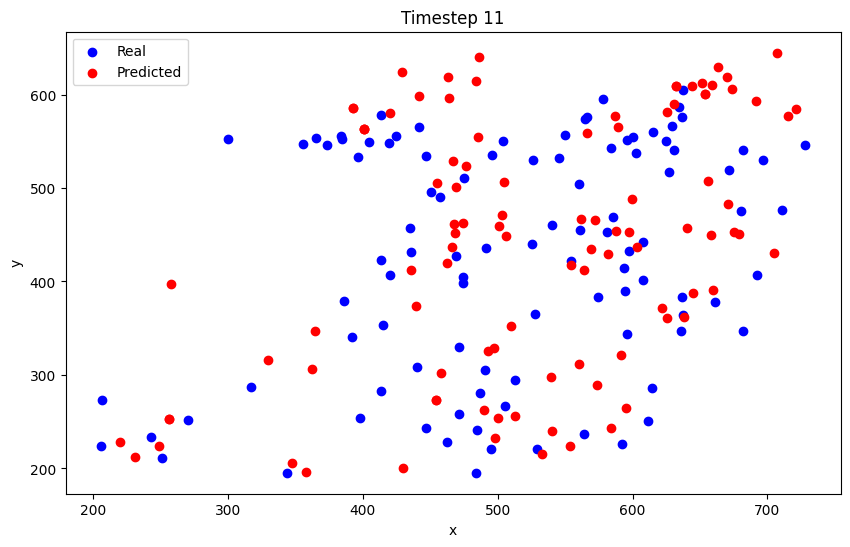

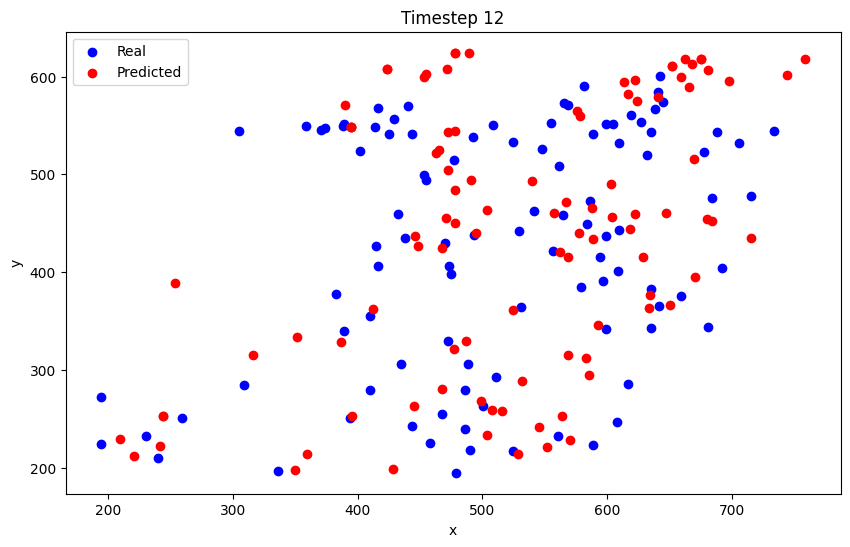

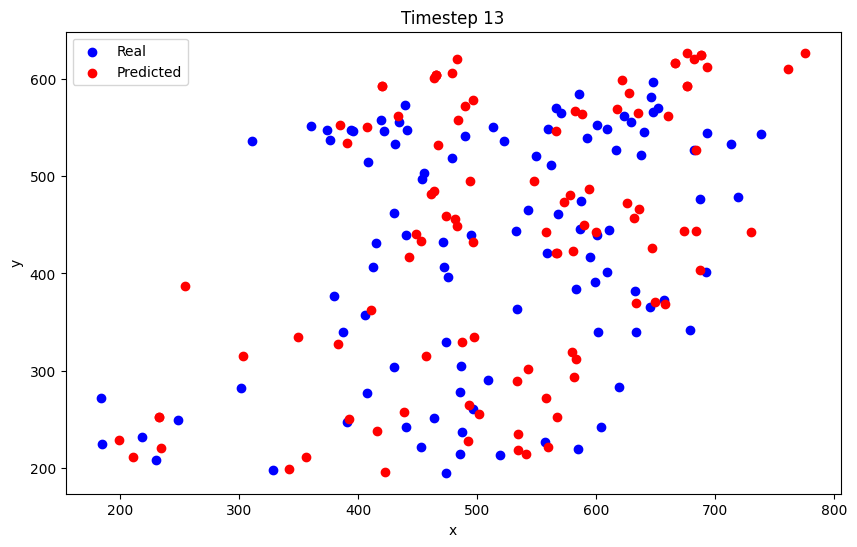

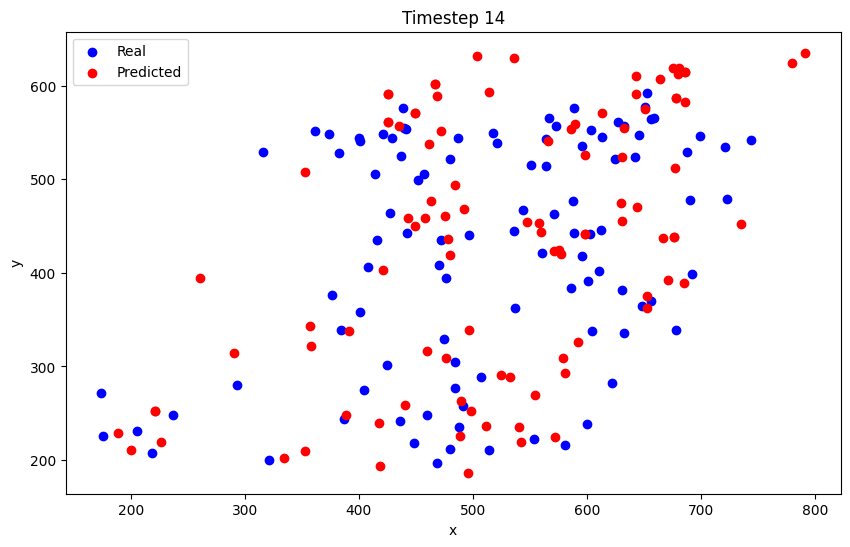

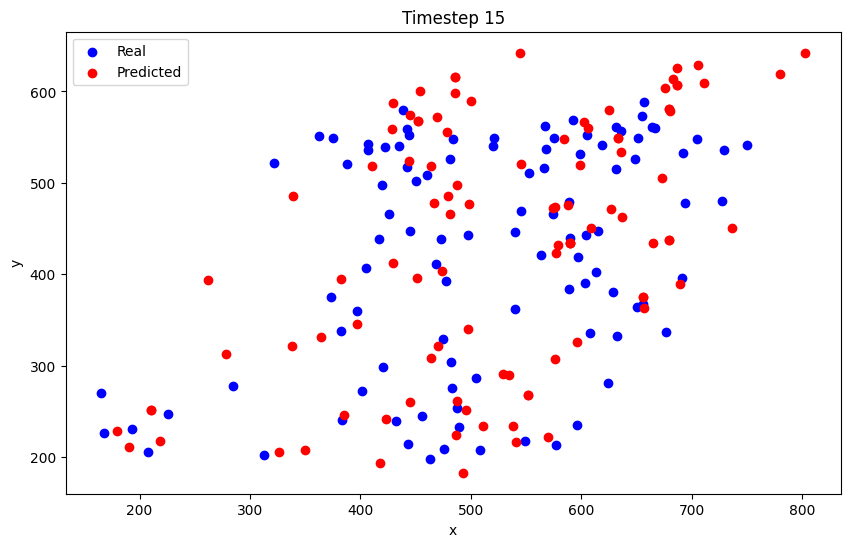

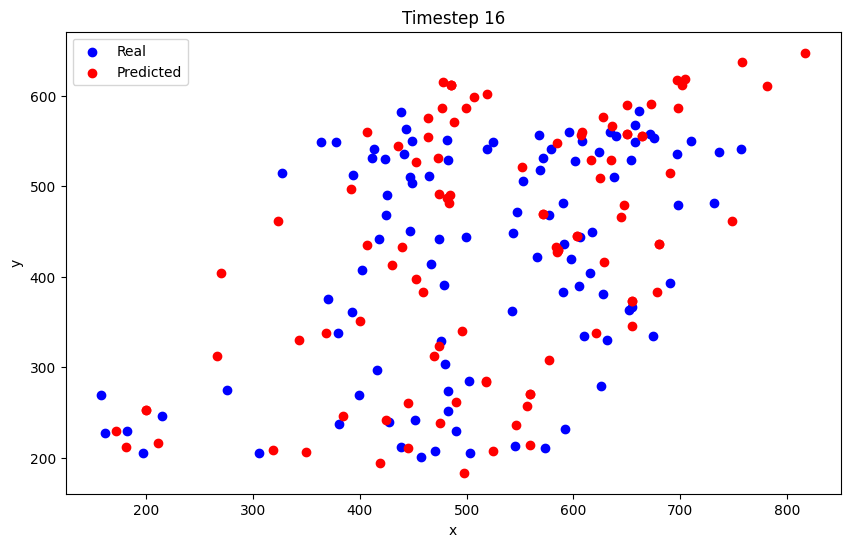

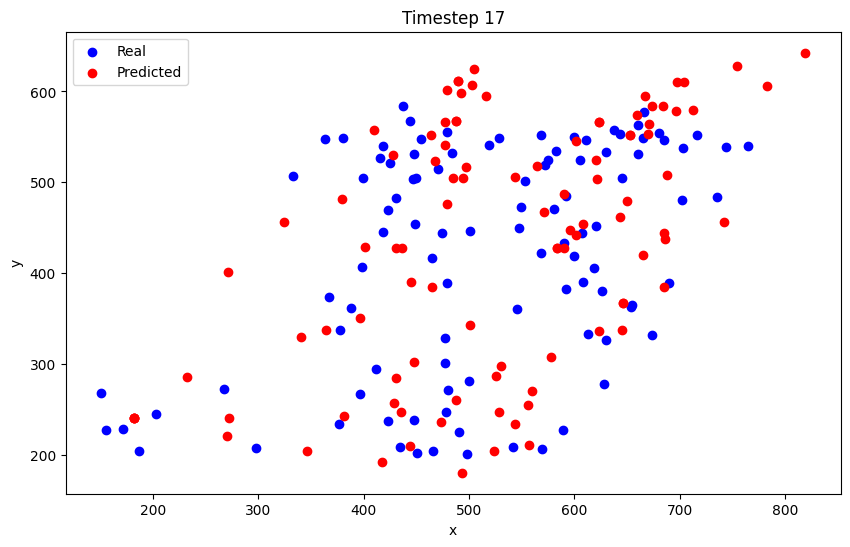

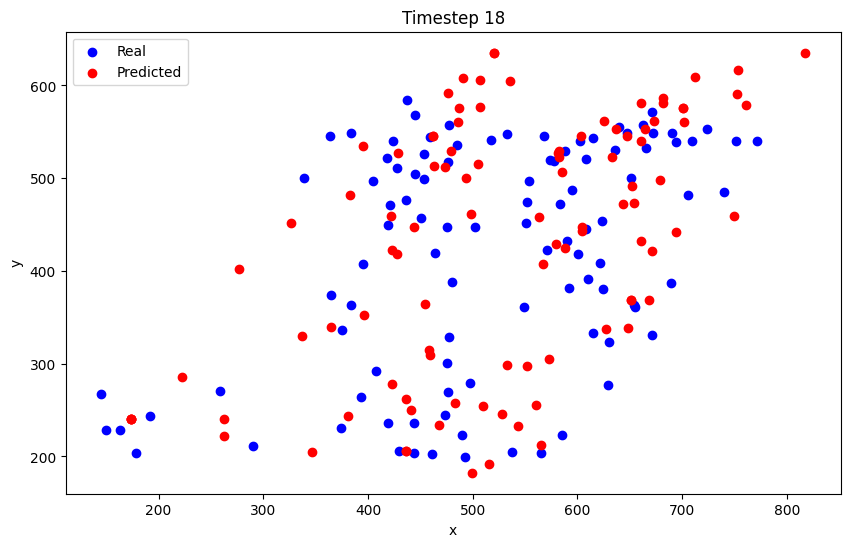

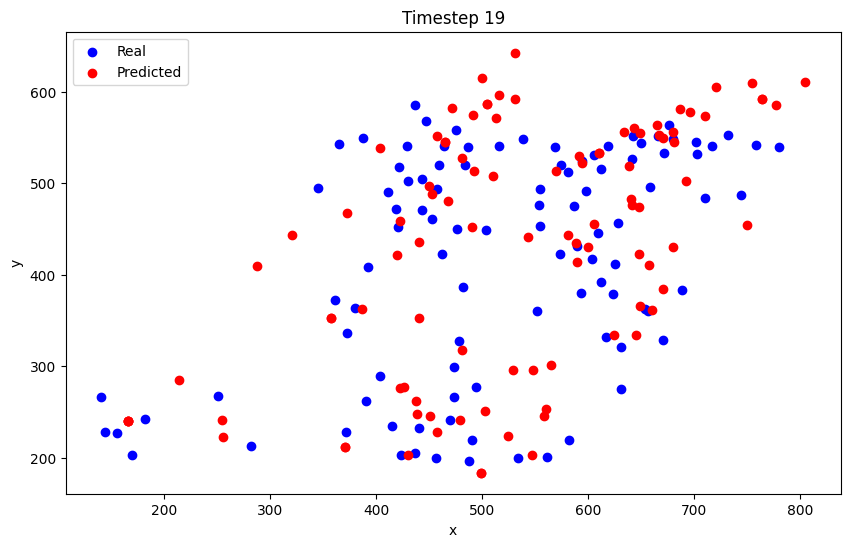

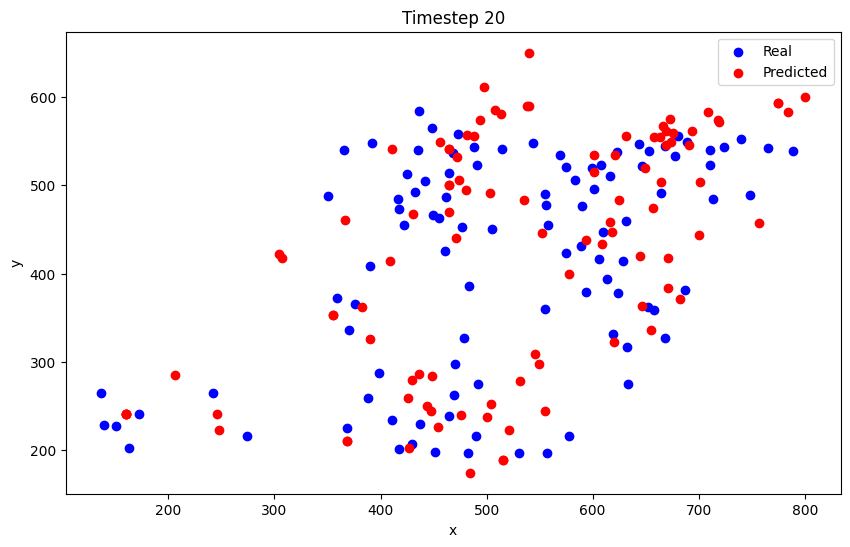

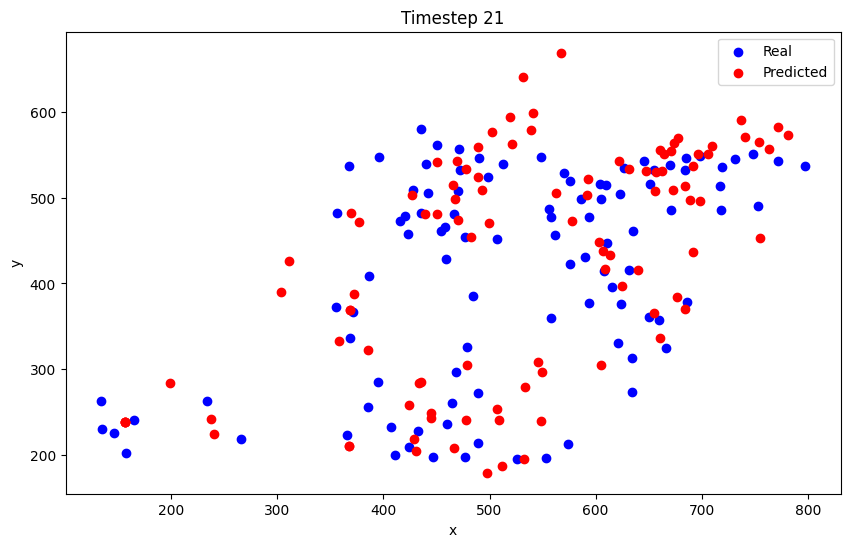

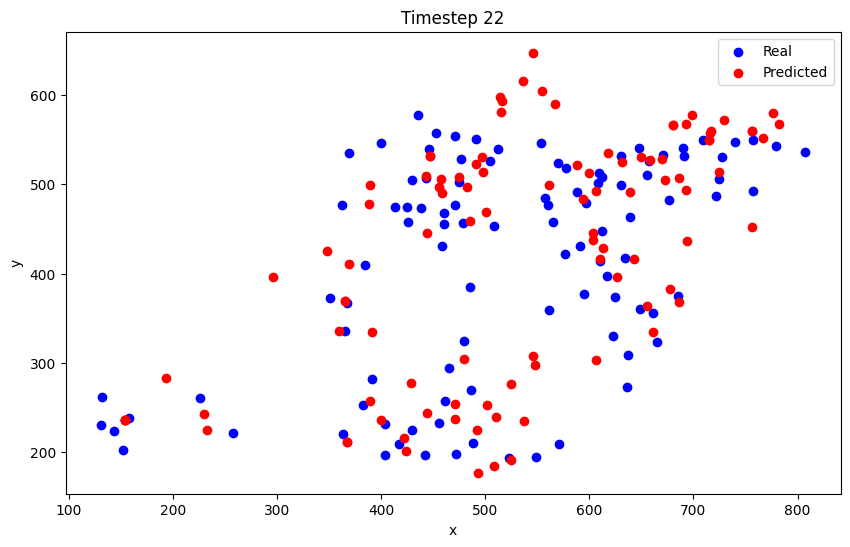

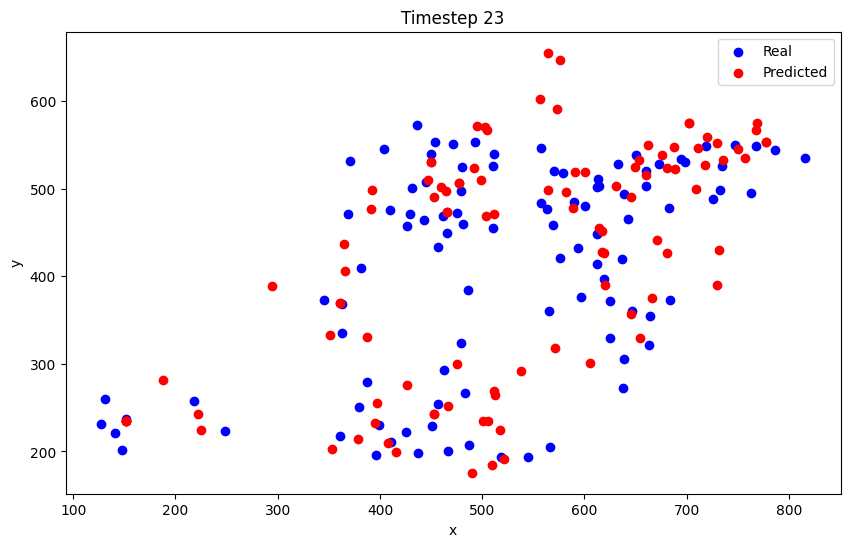

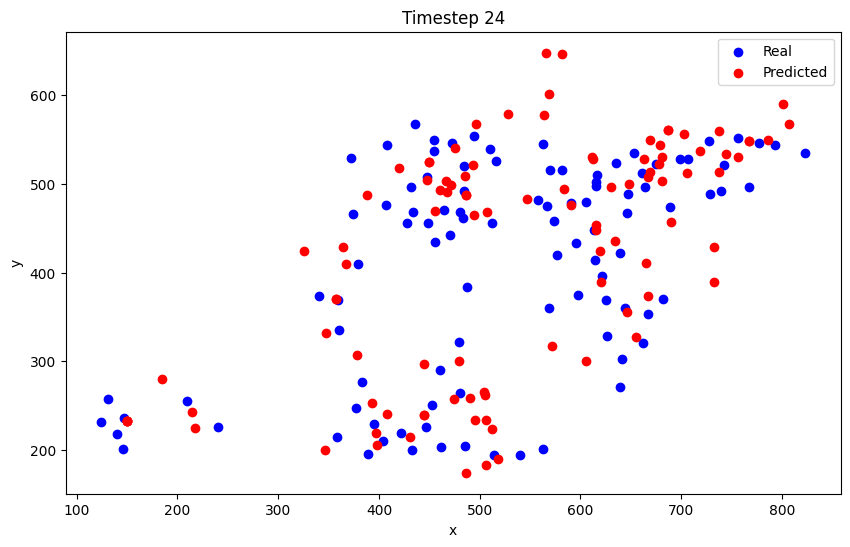

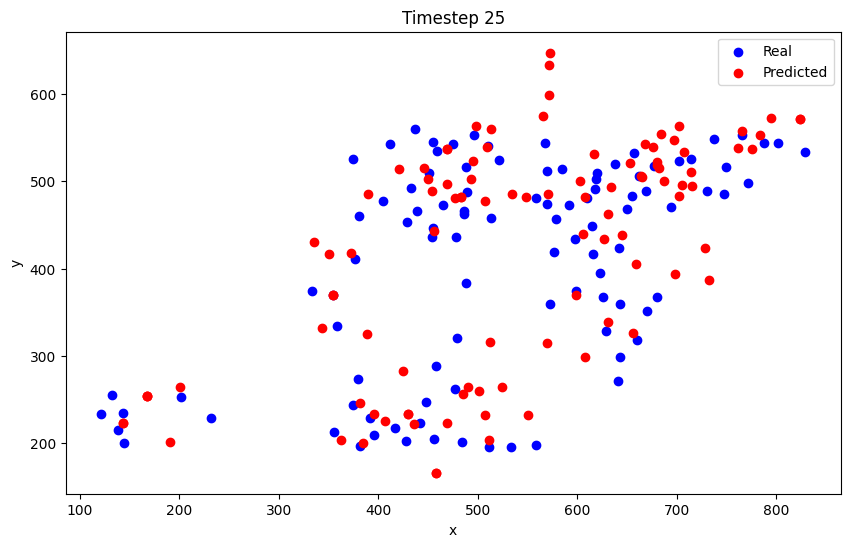

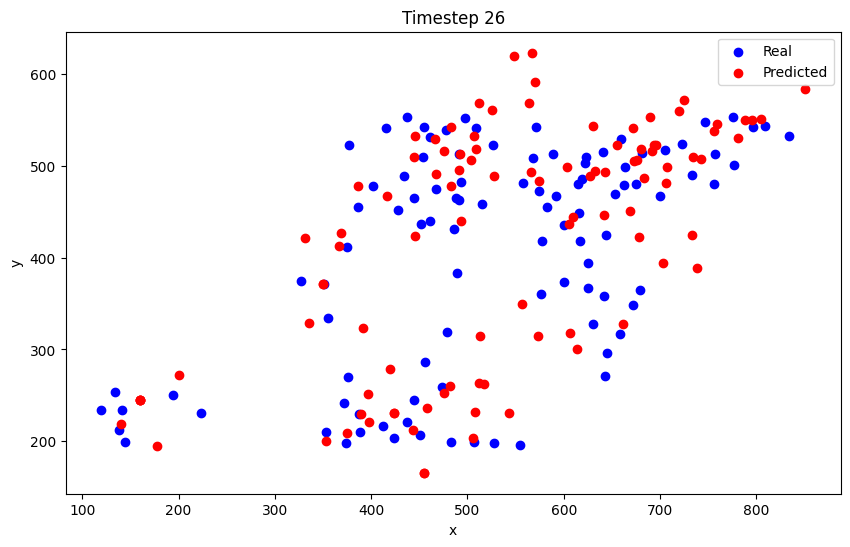

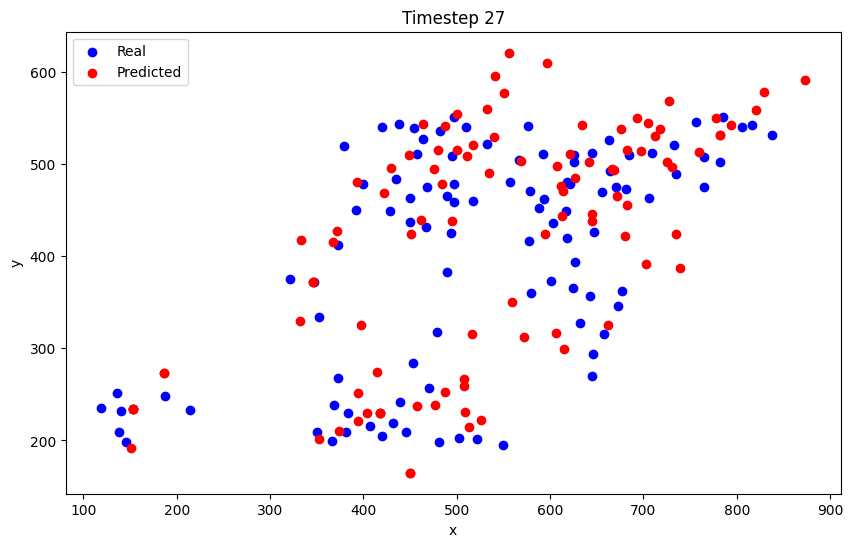

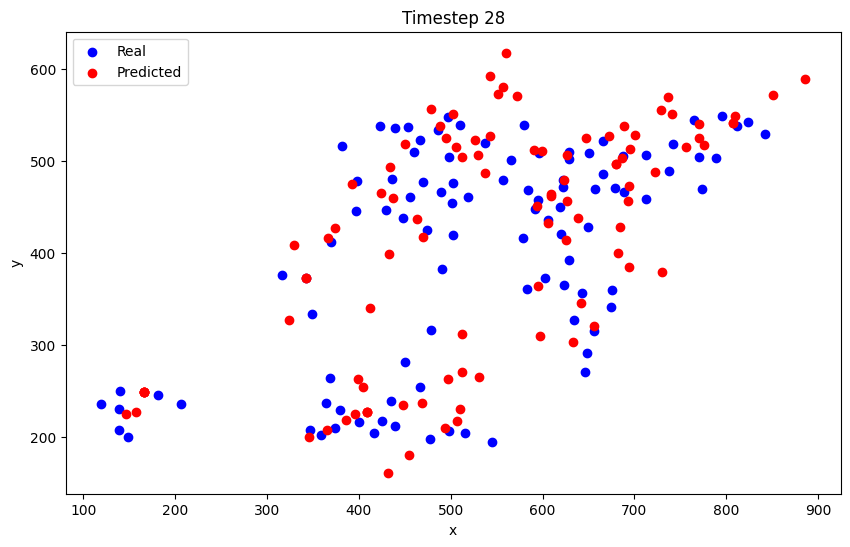

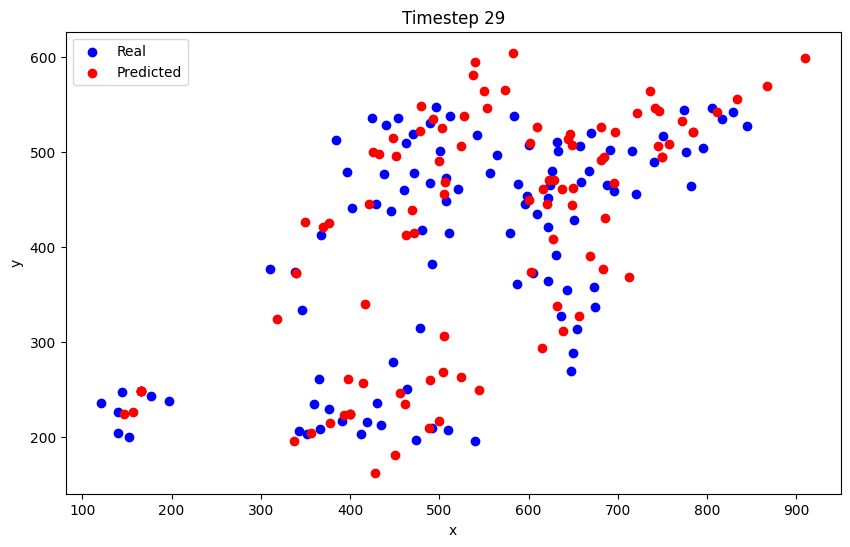

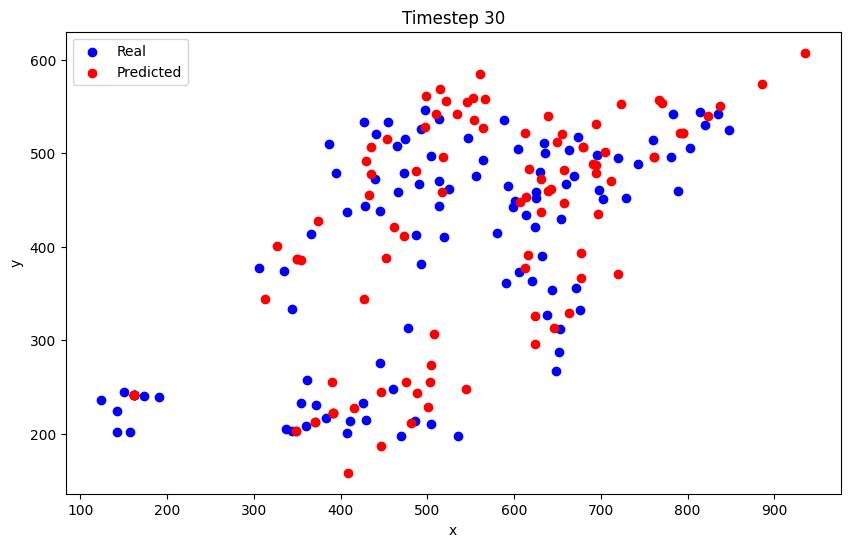

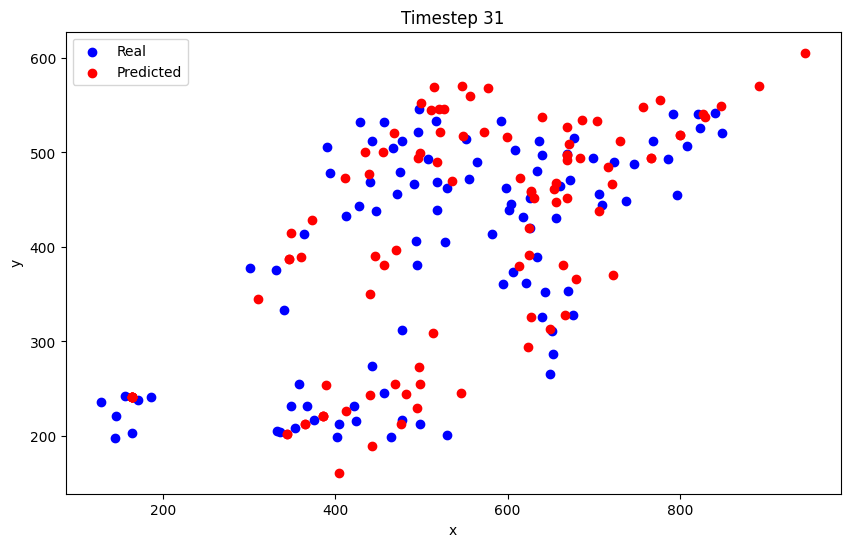

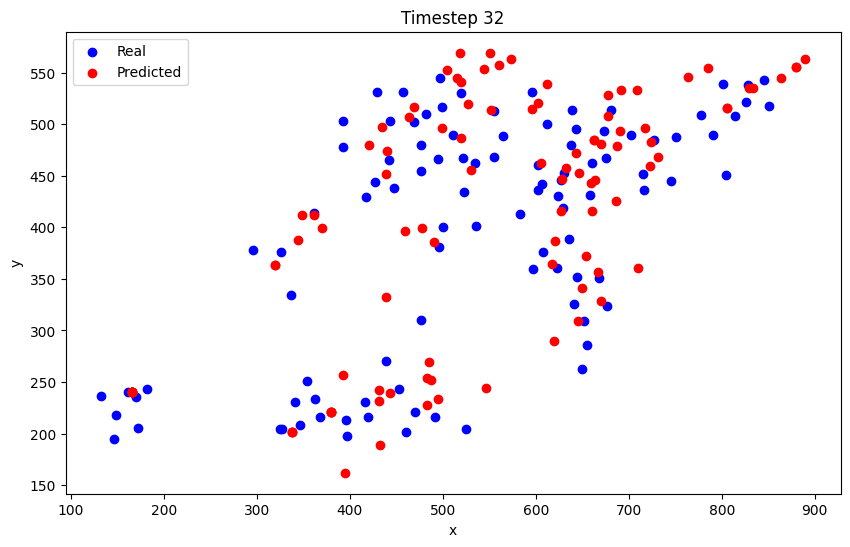

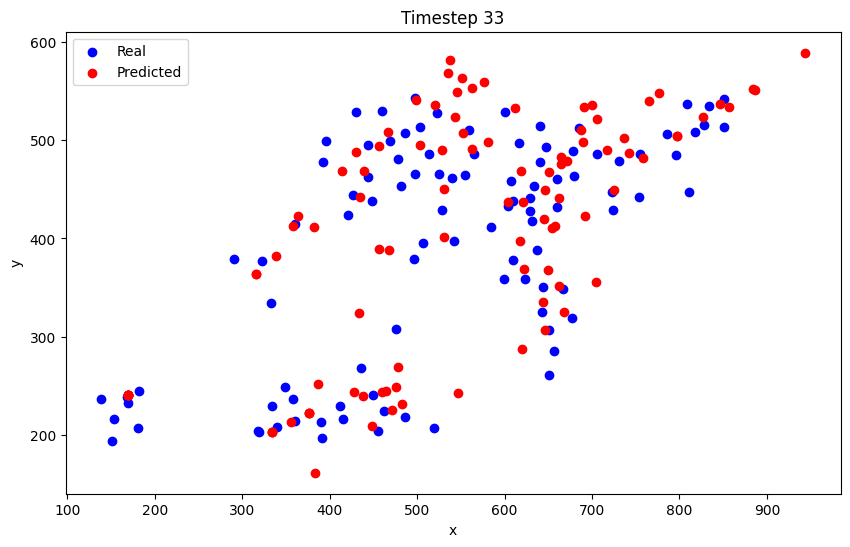

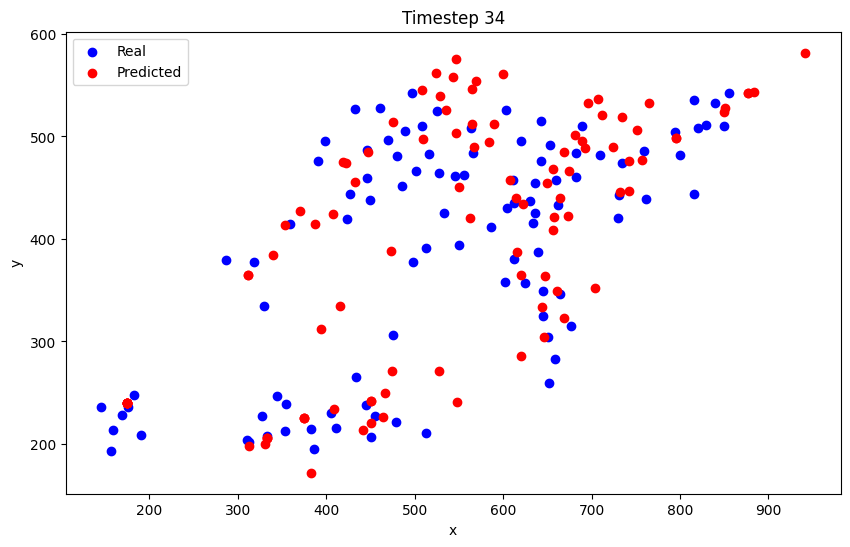

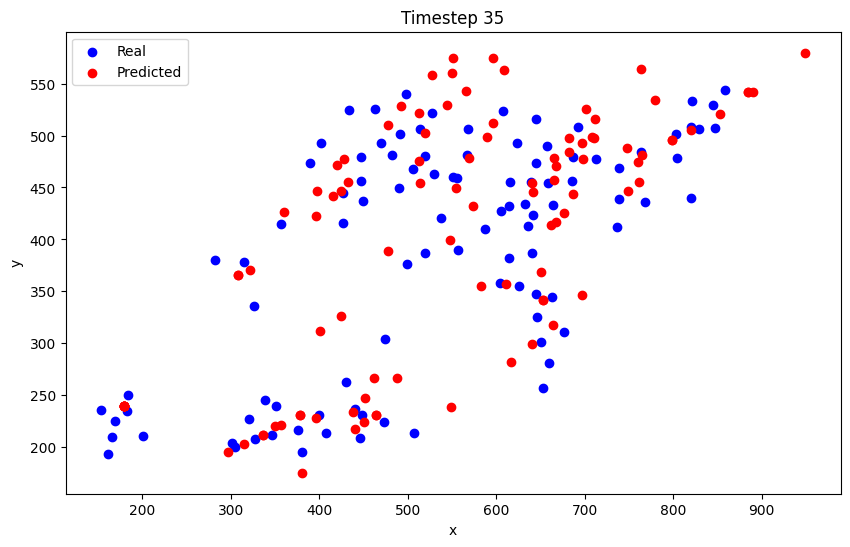

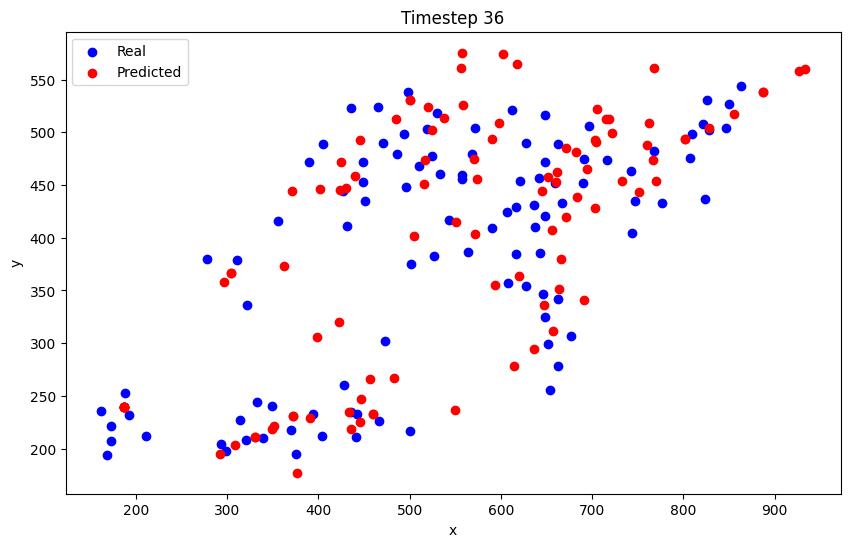

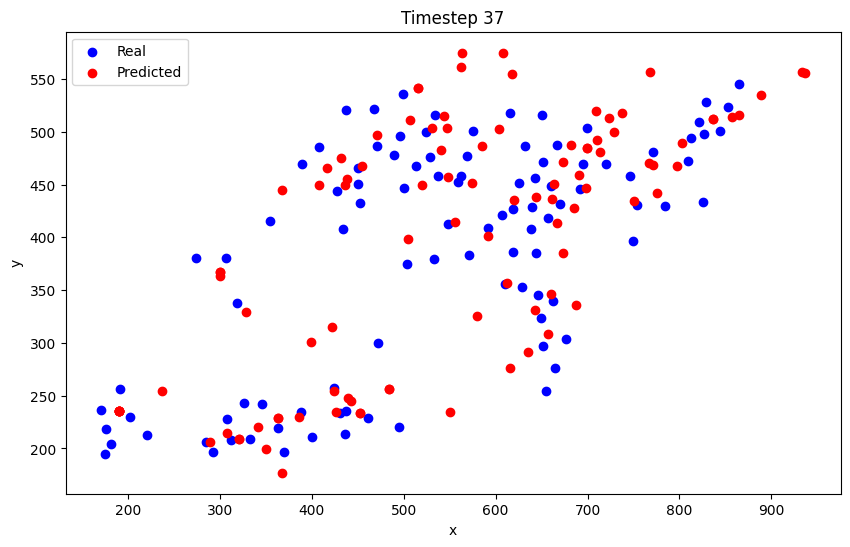

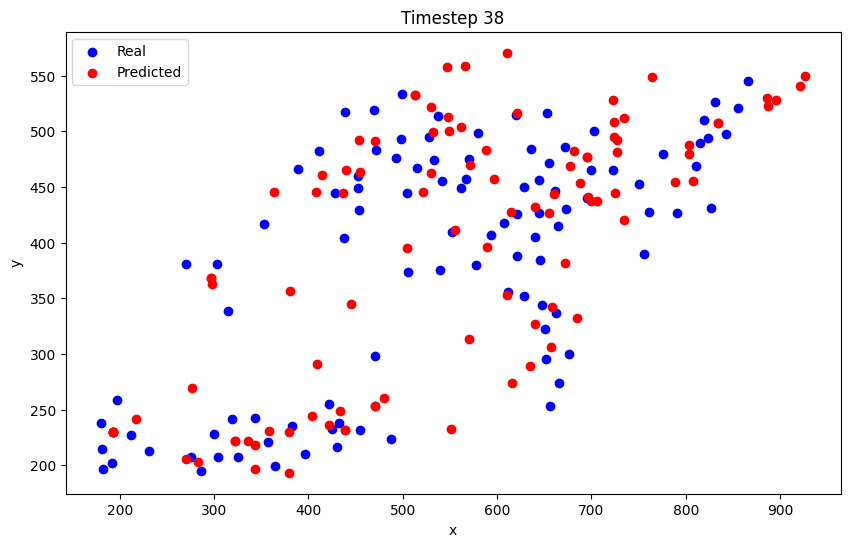

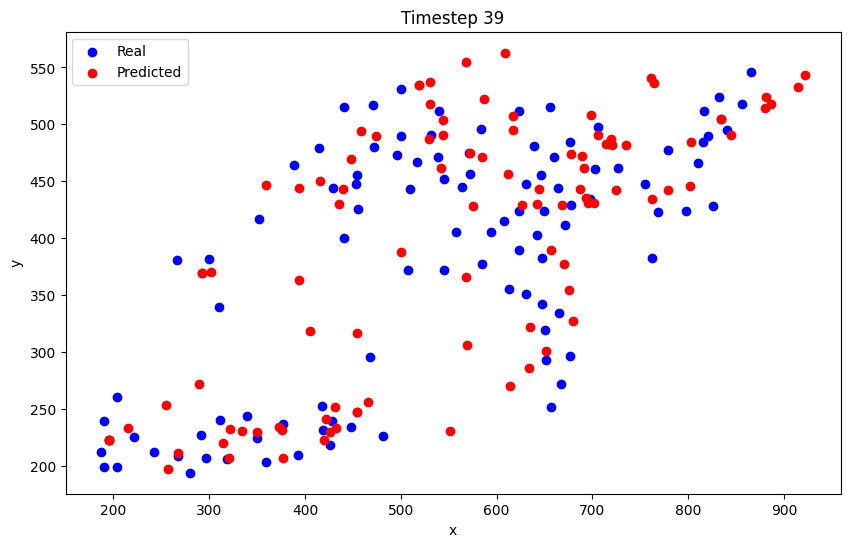

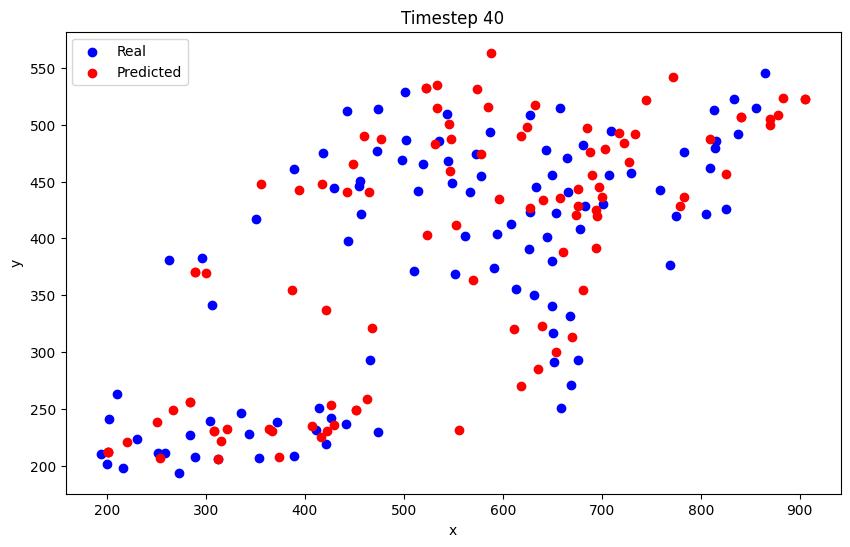

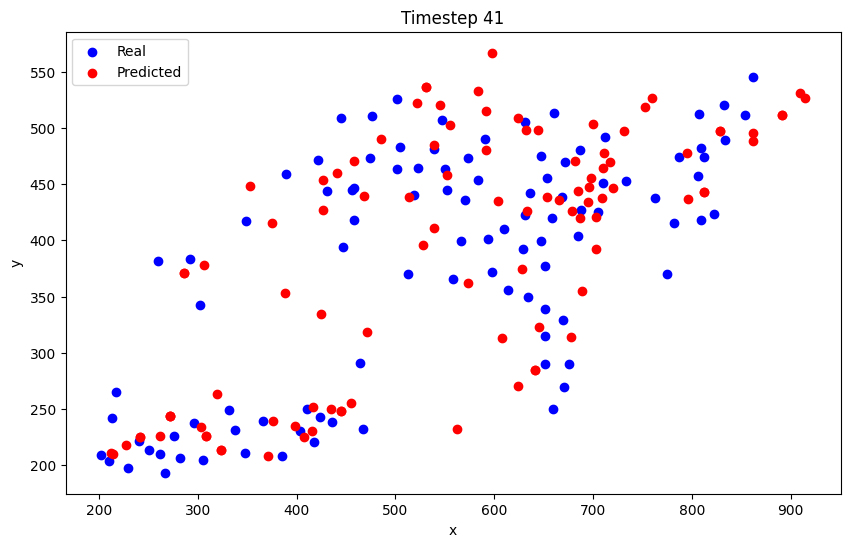

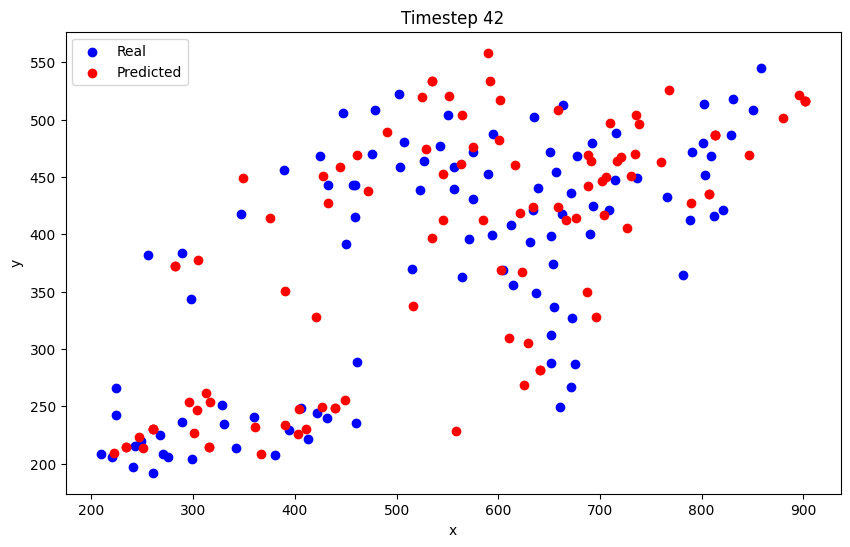

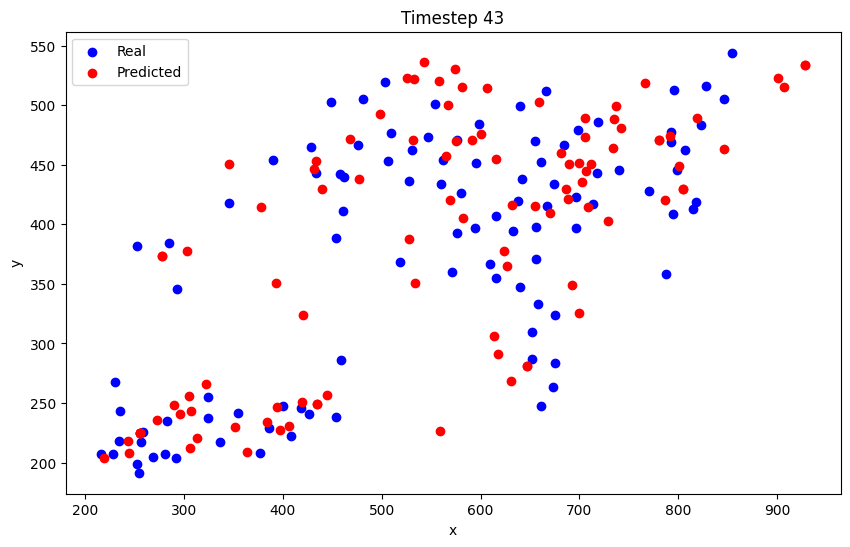

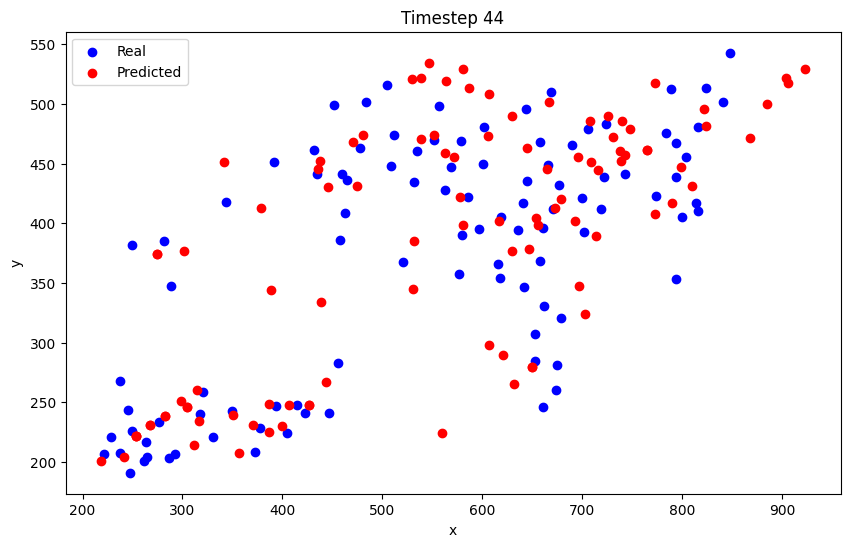

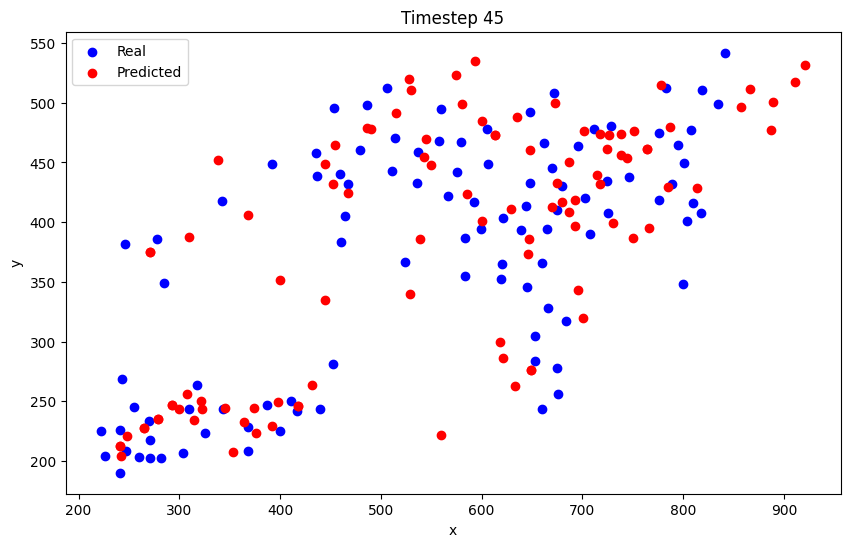

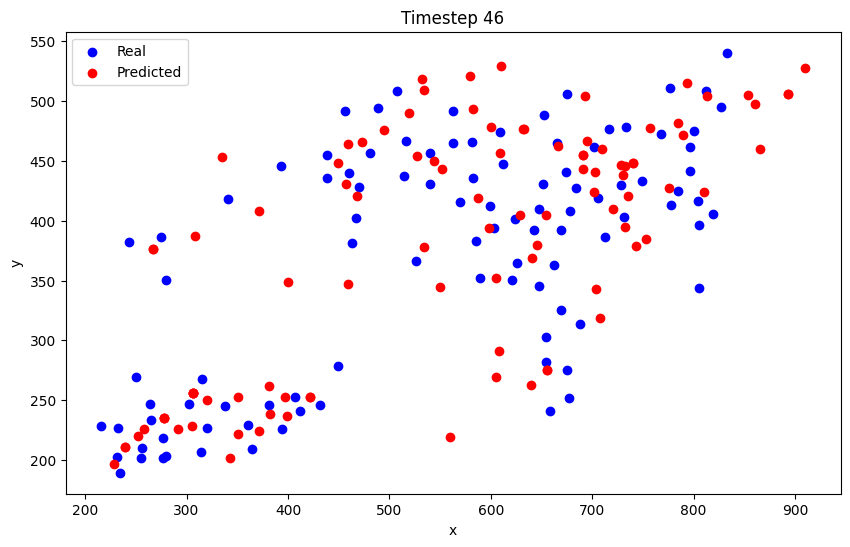

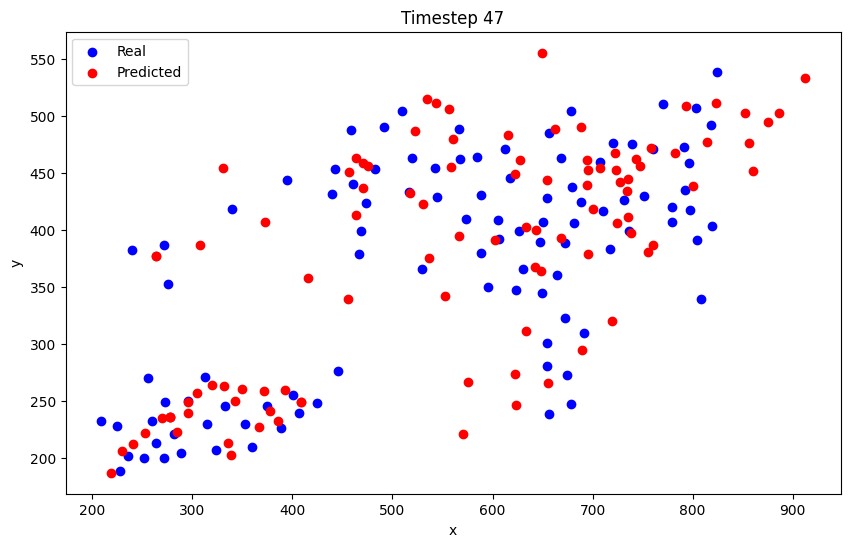

In [17]:
import math
import random
import pygame
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt

# Size of canvas
width = 1000
height = 750
numBoids = 100
visualRange = 75
boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def keepWithinBounds(boid):
    margin = 200
    turnFactor = 1
    if boid['x'] < margin:
        boid['dx'] += turnFactor
    if boid['x'] > width - margin:
        boid['dx'] -= turnFactor
    if boid['y'] < margin:
        boid['dy'] += turnFactor
    if boid['y'] > height - margin:
        boid['dy'] -= turnFactor

def flyTowardsCenter(boid):
    centeringFactor = 0.005
    centerX = 0
    centerY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1
    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors
        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX = 0
    moveY = 0
    for otherBoid in boids:
        if otherBoid != boid:
            if distance(boid, otherBoid) < minDistance:
                moveX += boid['x'] - otherBoid['x']
                moveY += boid['y'] - otherBoid['y']
    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05
    avgDX = 0
    avgDY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1
    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors
        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15
    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [
        (0, 0), (0, 10), (-15, 5)
    ])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)
        keepWithinBounds(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

# Save simulation data
pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10

for k in range(num_sims):
    initBoids()
    for _ in range(num_time_steps):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop()

    time_list = []
    for i in range(len(boids[0]["history"])):
        boid_dict = {}
        if i == 0:
            continue
        else:
            for j in range(len(boids)):
                dic = {}
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]
                boid_dict[f'boid{j}'] = dic

        time_list.append(boid_dict)

    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

pygame.quit()

# Load and preprocess data
def load_and_preprocess_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    num_timesteps = len(data)
    num_boids = len(data[0])

    features_list = []
    adjacency_matrices = []

    for t in range(num_timesteps):
        features = np.zeros((num_boids, 4))
        for i in range(num_boids):
            boid_data = data[t][f'boid{i}']
            features[i, 0] = boid_data['x']
            features[i, 1] = boid_data['y']
            features[i, 2] = boid_data['dx']
            features[i, 3] = boid_data['dy']
        
        adjacency_matrix = np.zeros((num_boids, num_boids))
        for i in range(num_boids):
            for j in range(num_boids):
                if i != j and distance(data[t][f'boid{i}'], data[t][f'boid{j}']) < visualRange:
                    adjacency_matrix[i, j] = 1
        
        features_list.append(torch.tensor(features, dtype=torch.float))
        adjacency_matrices.append(torch.tensor(adjacency_matrix, dtype=torch.float))
    
    return features_list, adjacency_matrices

features_list, adjacency_matrices = load_and_preprocess_data("../data/myjson/mydata1.json")

print("Features shape:", features_list[0].shape)
print("Adjacency matrix shape:", adjacency_matrices[0].shape)

# Define GRNN Generator
class GRNNGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GRNNGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
    
    def forward(self, features, edge_index):
        x = self.encoder(features, edge_index)
        x = F.relu(x)
        x = self.decoder(x)
        return x

# Initialize the generator
generator = GRNNGenerator(in_channels=4, hidden_channels=16, out_channels=4)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the discriminator
discriminator = Discriminator(input_dim=4, hidden_dim=16)

# Hyperparameters
num_epochs = 1000
batch_size = 32
learning_rate = 0.0001

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Plotting generator predictions
with torch.no_grad():
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()
        predicted_features = generator(real_features, edge_index).numpy()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', label='Real')
        plt.scatter(predicted_features[:, 0], predicted_features[:, 1], c='red', label='Predicted')
        plt.legend()
        plt.title(f'Timestep {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()


Features shape: torch.Size([100, 4])
Adjacency matrix shape: torch.Size([100, 100])
Epoch [1/100], Step [1/48], D Loss: 4.803360462188721, G Loss: 0.017383957281708717
Epoch [1/100], Step [2/48], D Loss: 4.920804023742676, G Loss: 0.015594891272485256
Epoch [1/100], Step [3/48], D Loss: 5.032176971435547, G Loss: 0.013818071223795414
Epoch [1/100], Step [4/48], D Loss: 5.1354146003723145, G Loss: 0.012516217306256294
Epoch [1/100], Step [5/48], D Loss: 5.249754428863525, G Loss: 0.011440634727478027
Epoch [1/100], Step [6/48], D Loss: 5.350518226623535, G Loss: 0.010545369237661362
Epoch [1/100], Step [7/48], D Loss: 5.459827899932861, G Loss: 0.009324044920504093
Epoch [1/100], Step [8/48], D Loss: 5.5571112632751465, G Loss: 0.008590356446802616
Epoch [1/100], Step [9/48], D Loss: 5.654961109161377, G Loss: 0.008059453219175339
Epoch [1/100], Step [10/48], D Loss: 5.752613544464111, G Loss: 0.007611033972352743
Epoch [1/100], Step [11/48], D Loss: 5.8437275886535645, G Loss: 0.007279

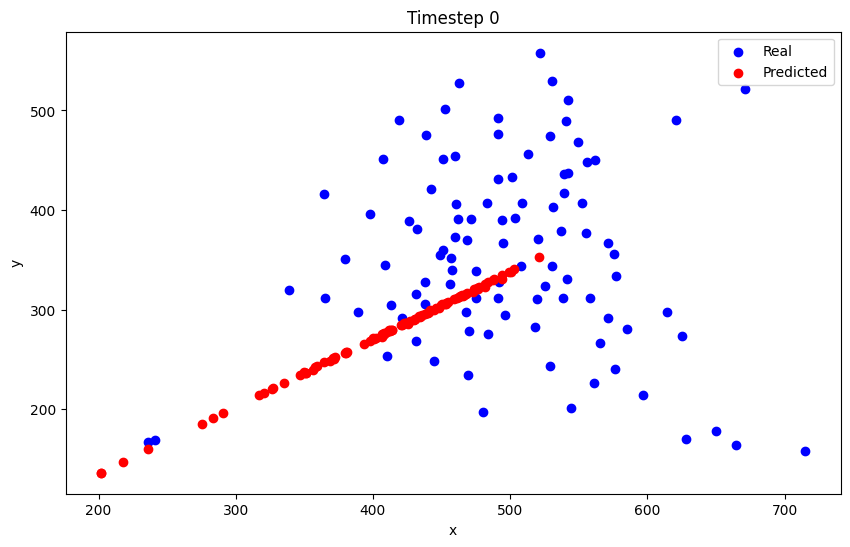

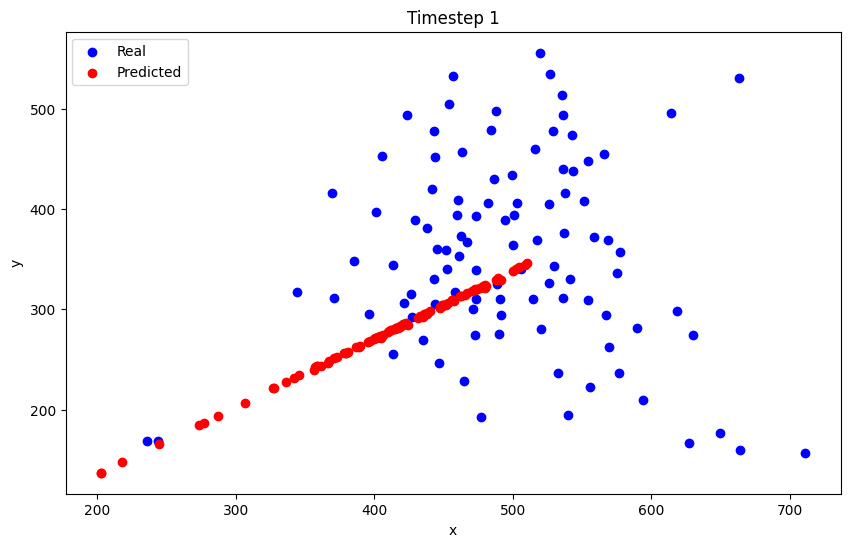

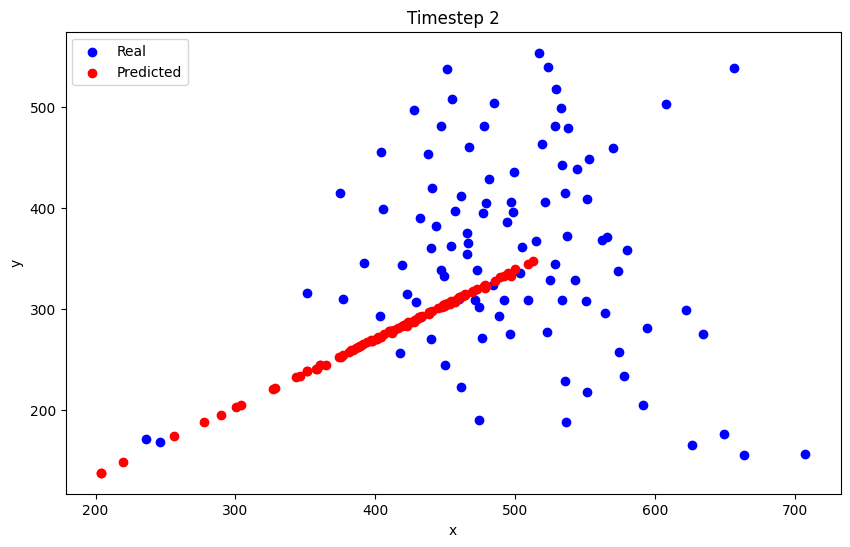

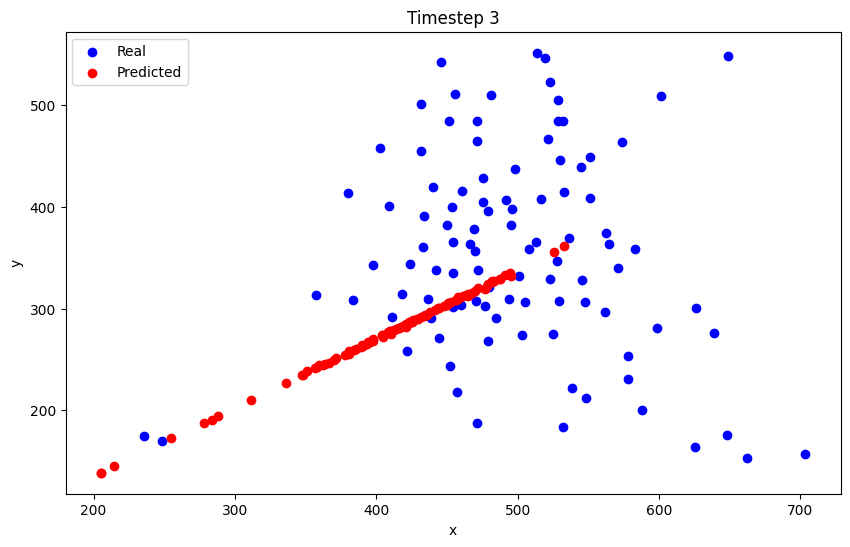

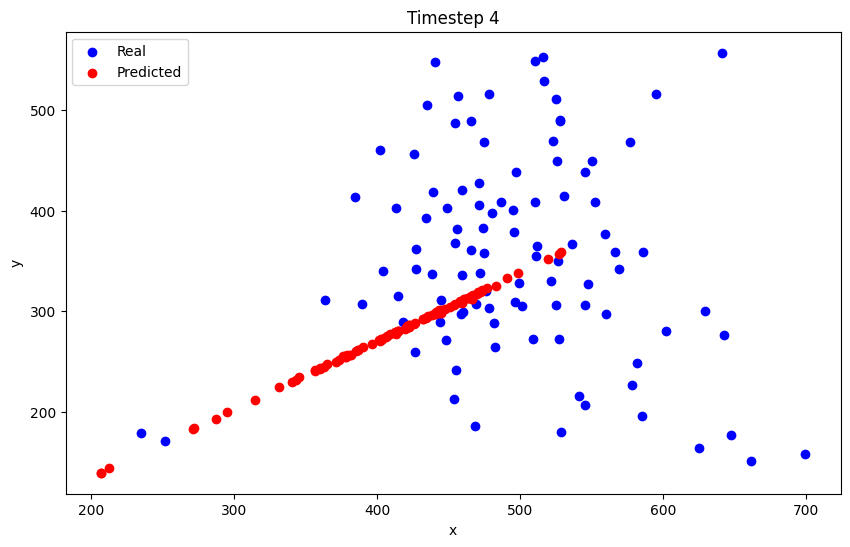

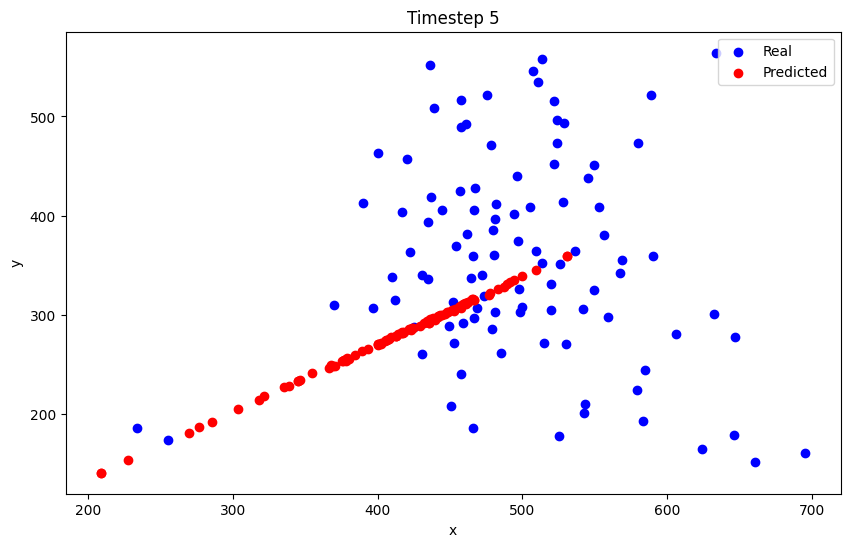

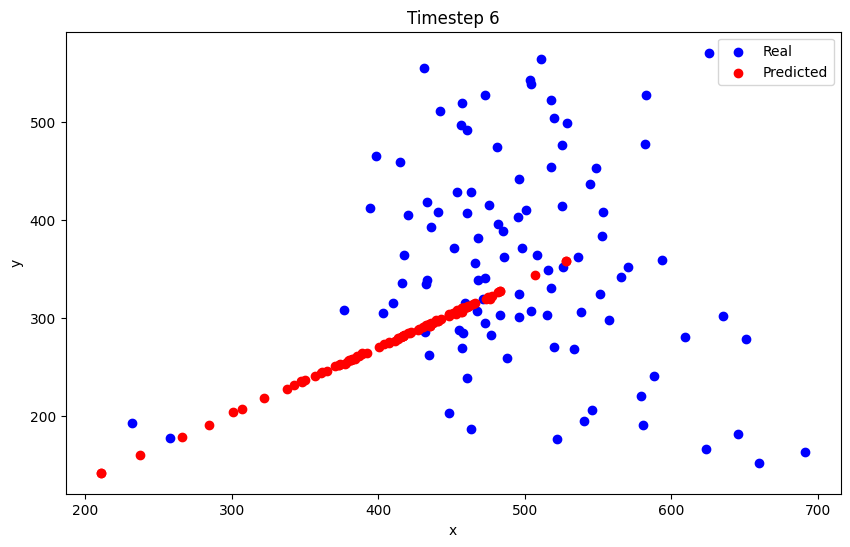

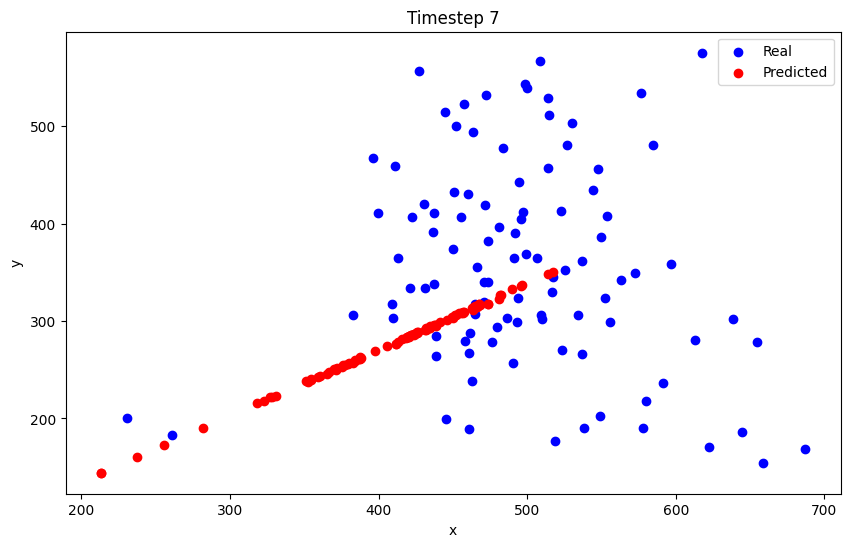

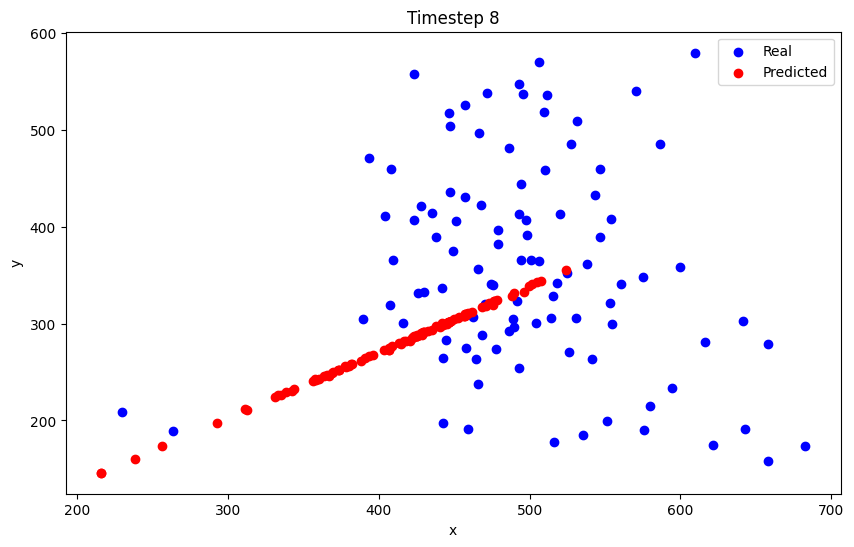

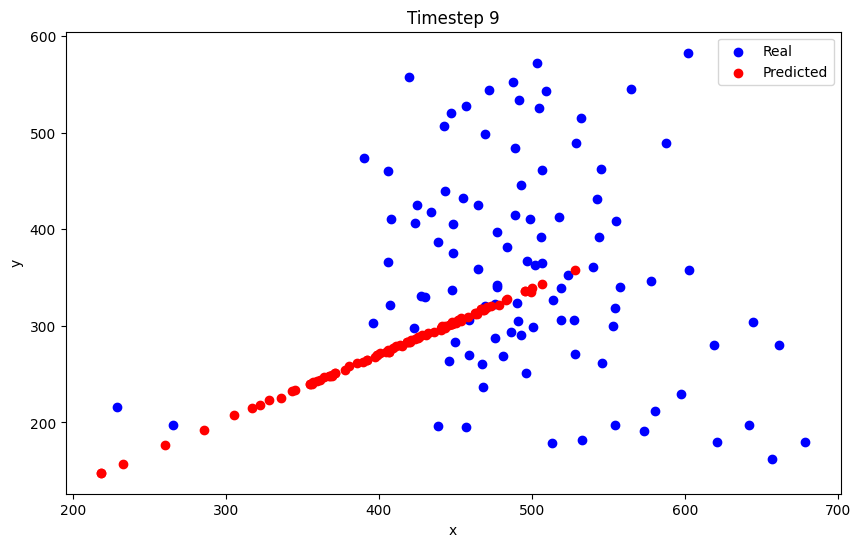

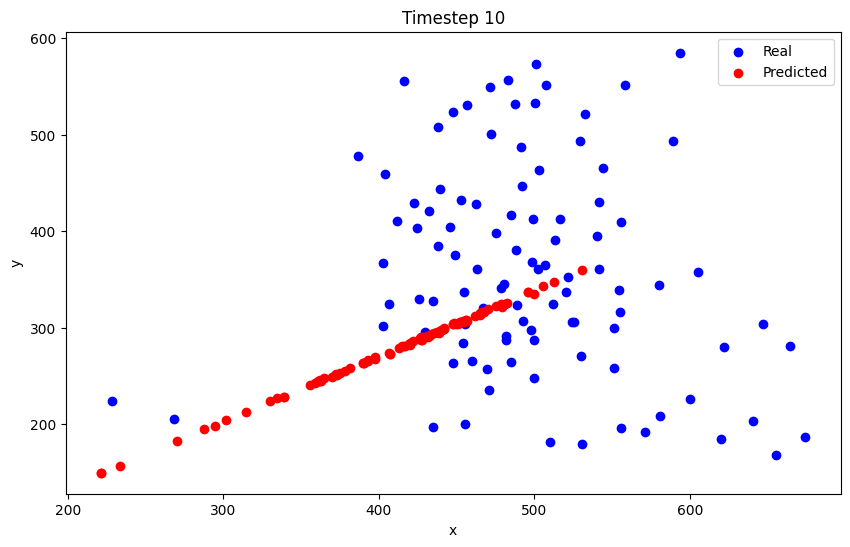

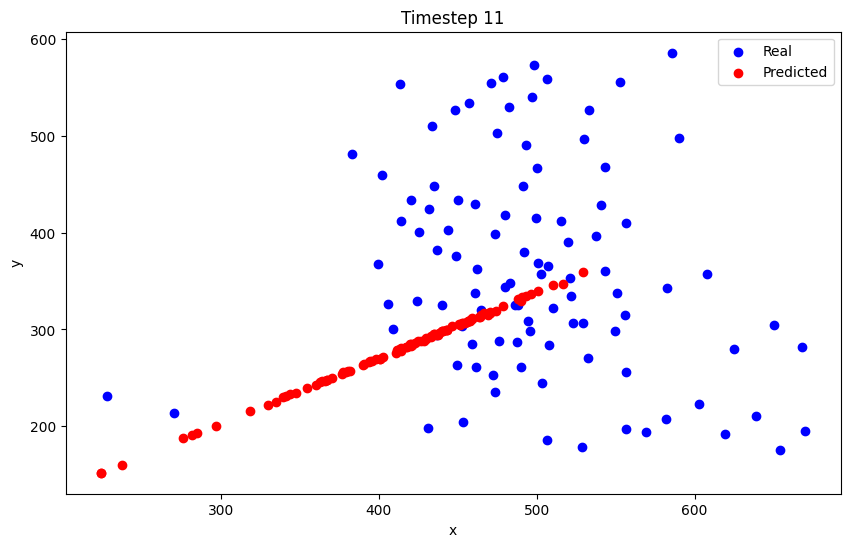

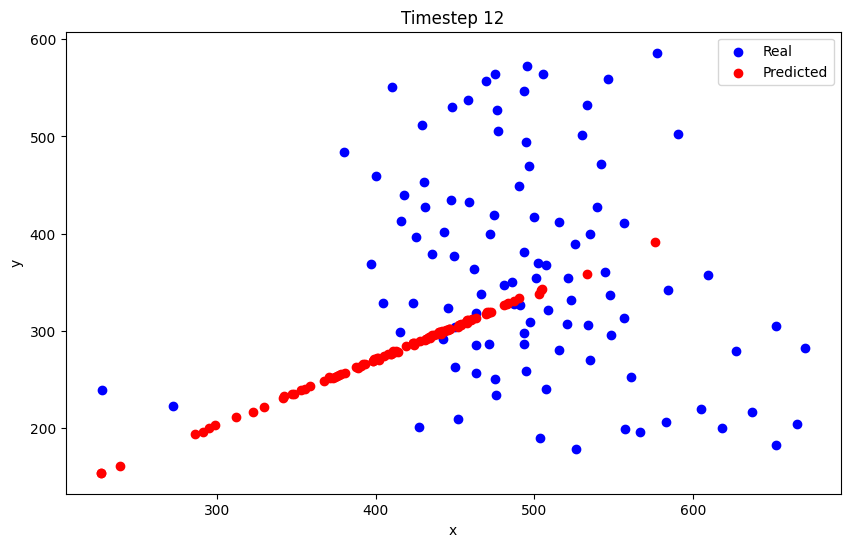

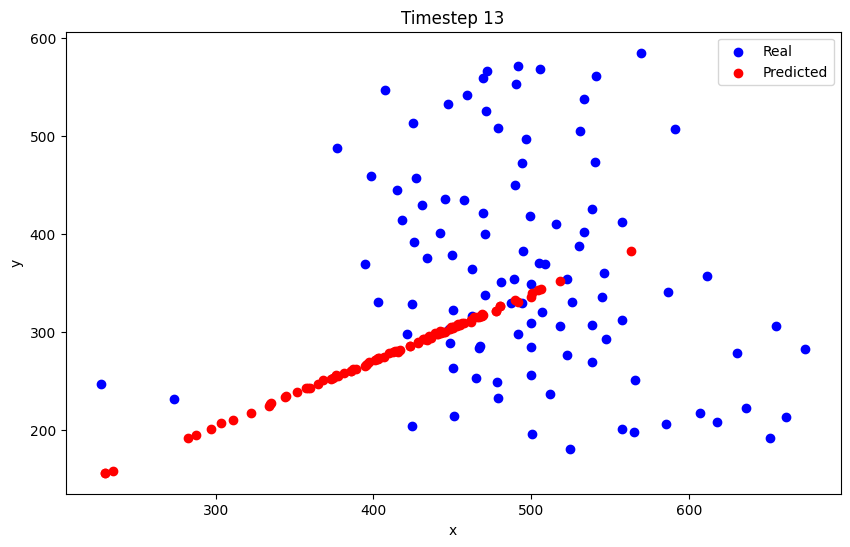

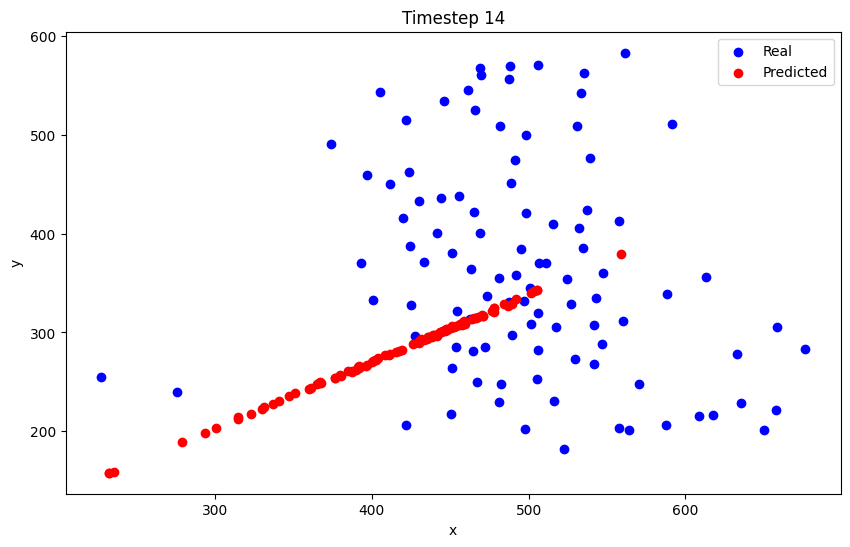

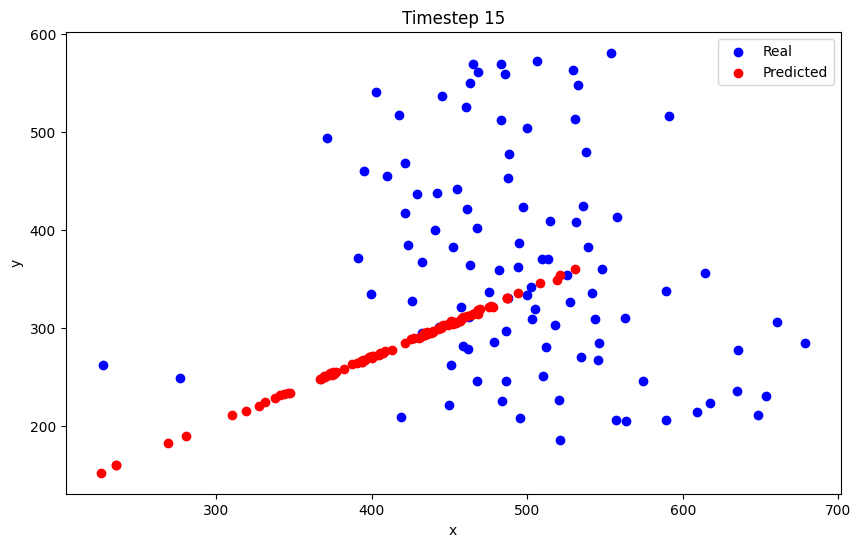

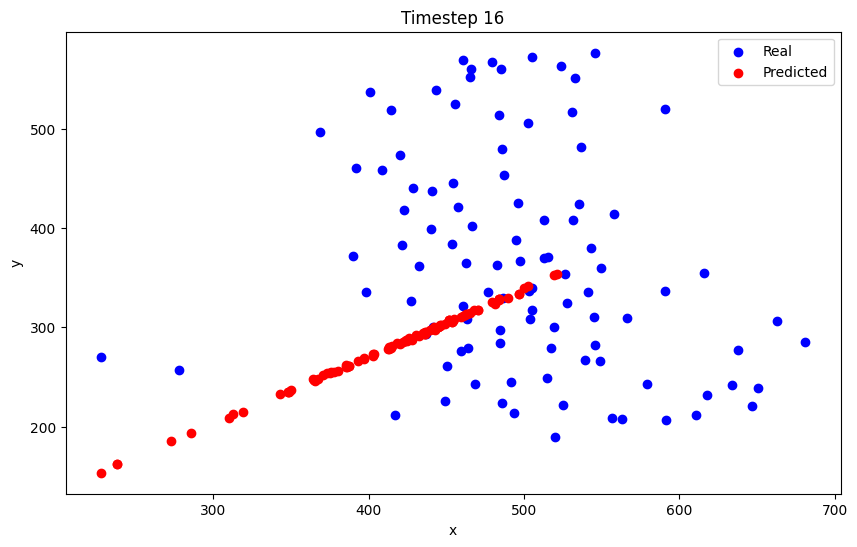

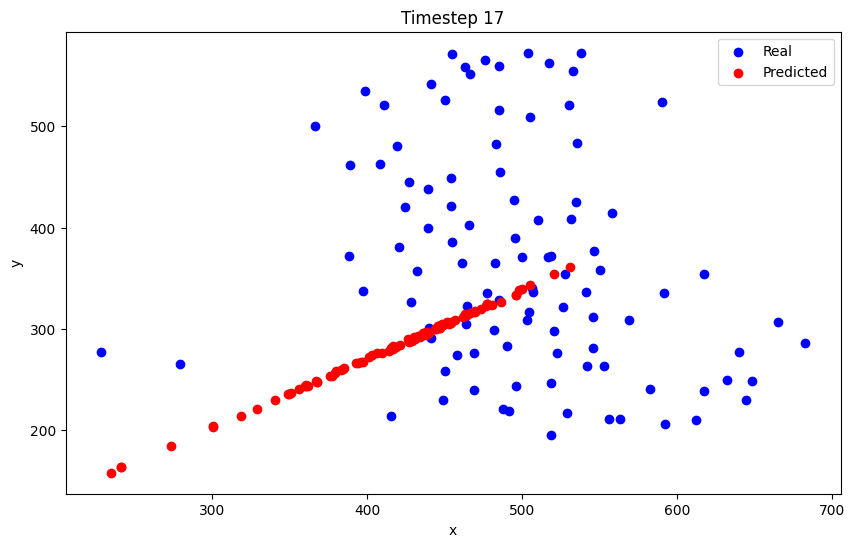

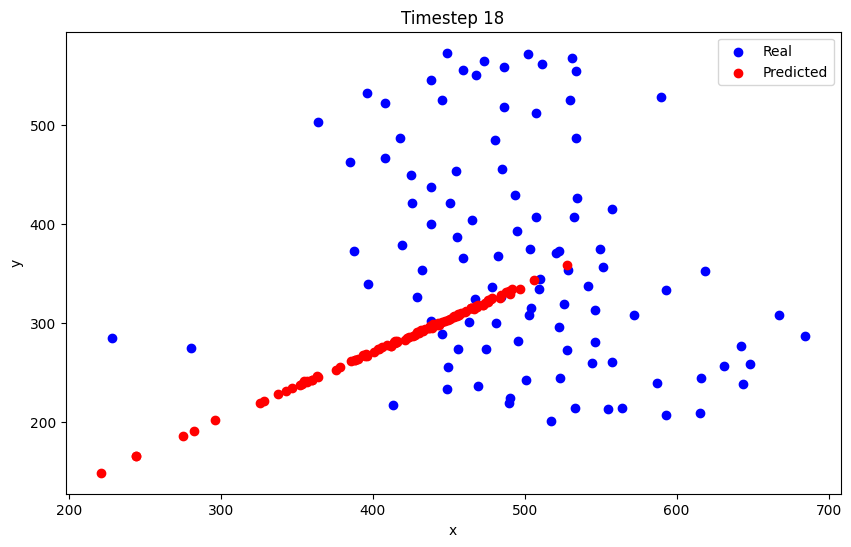

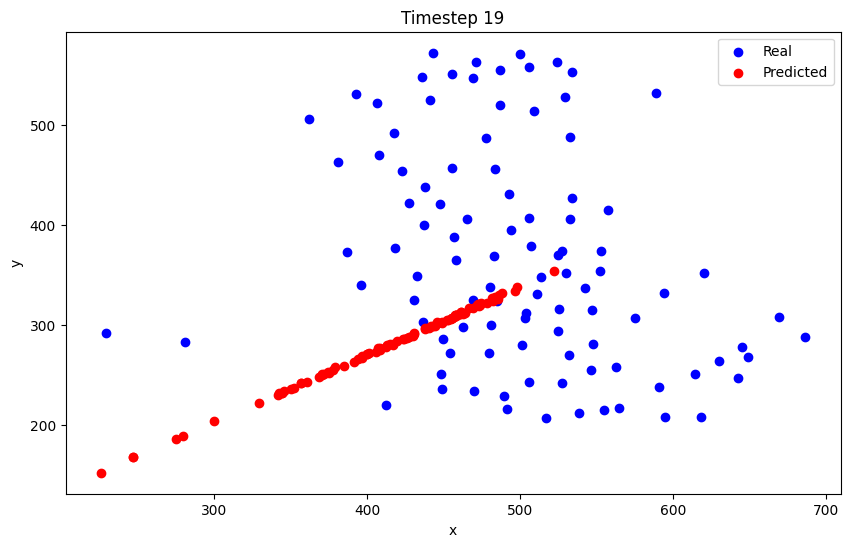

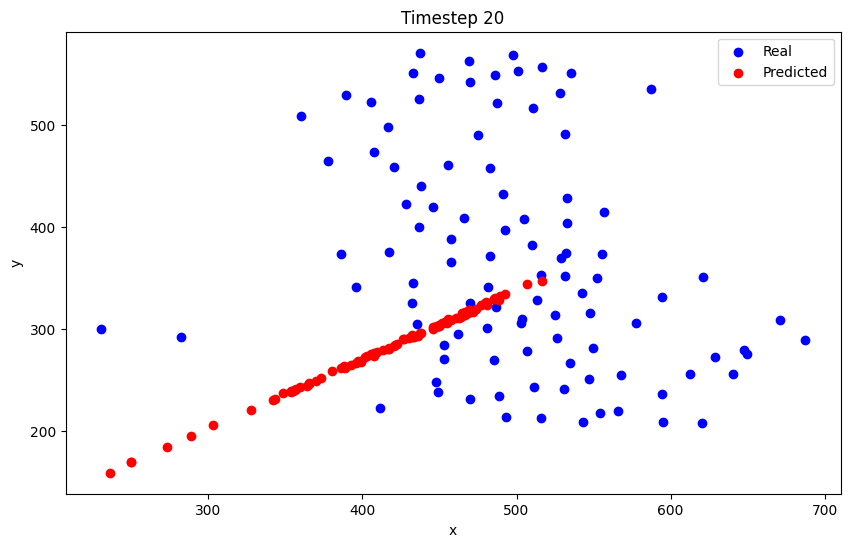

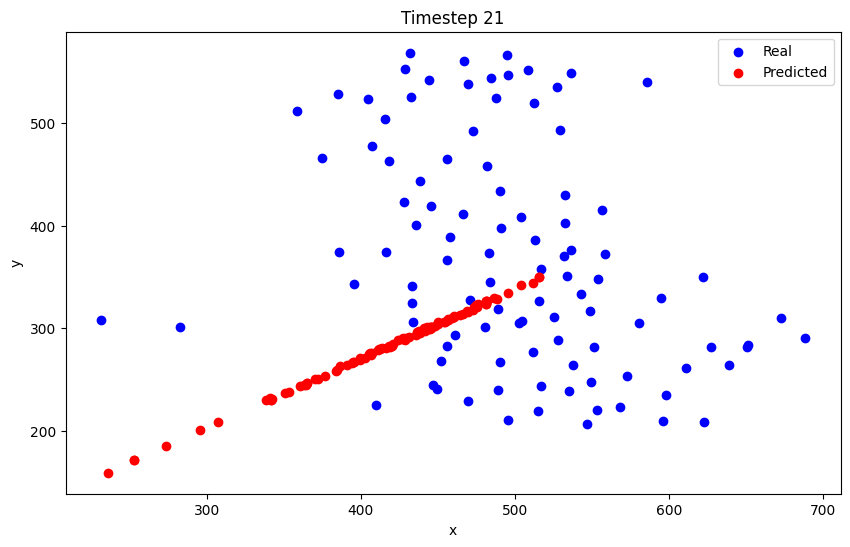

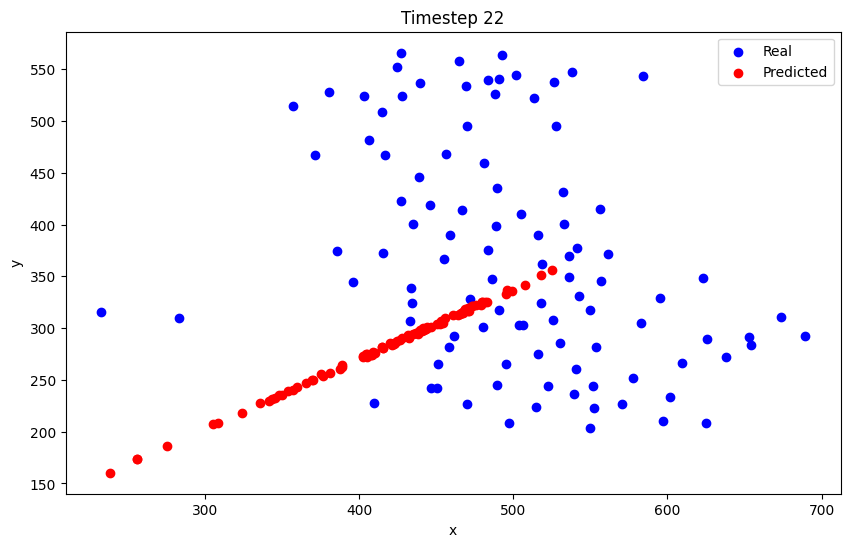

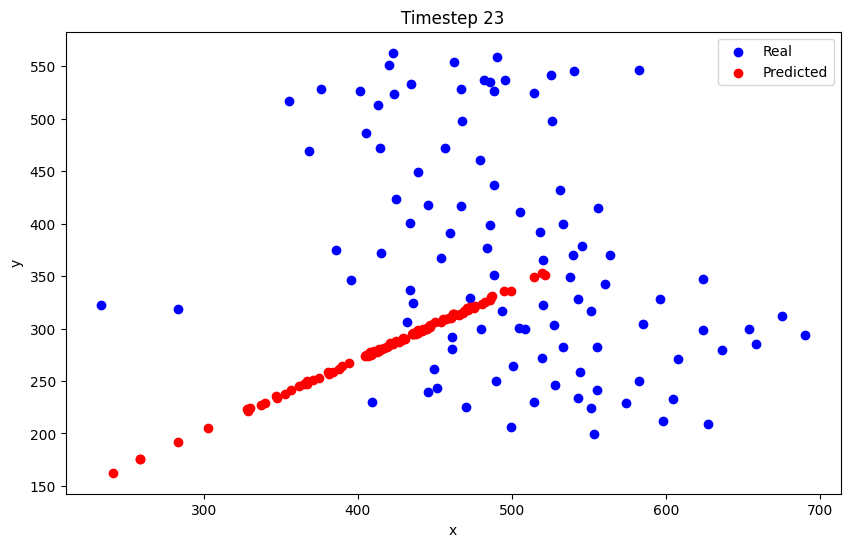

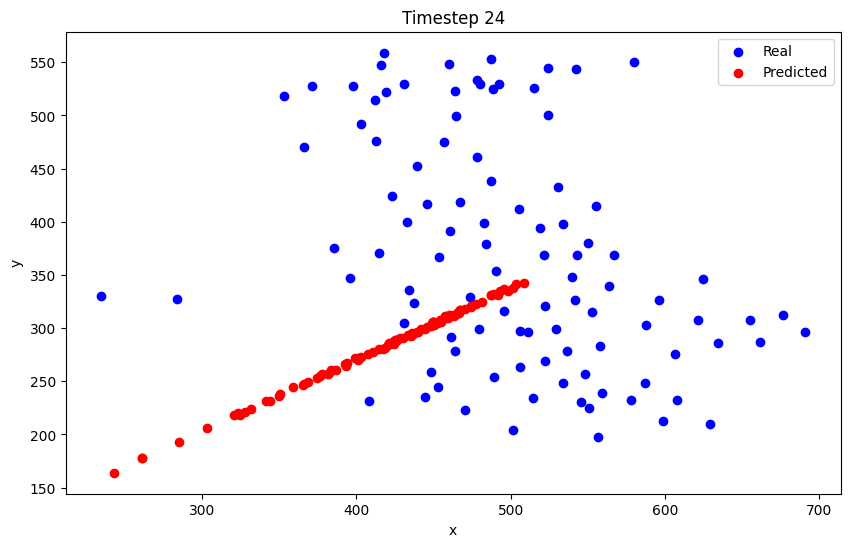

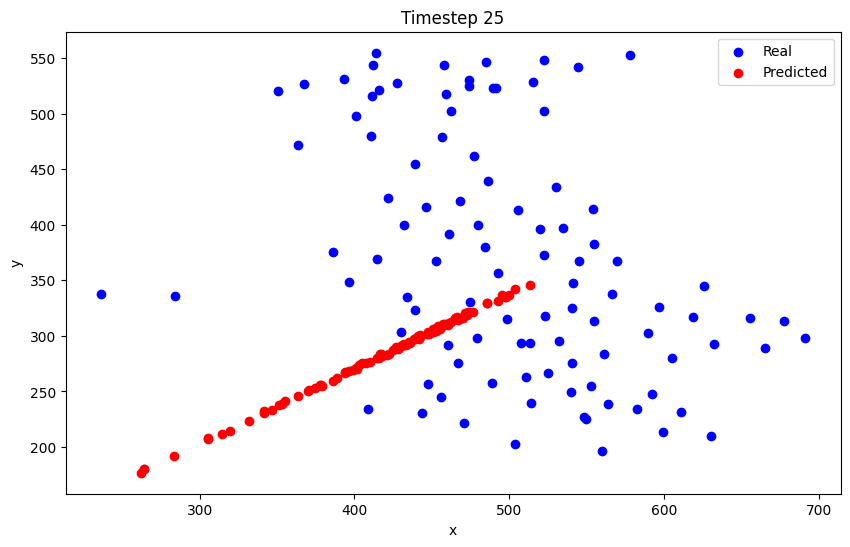

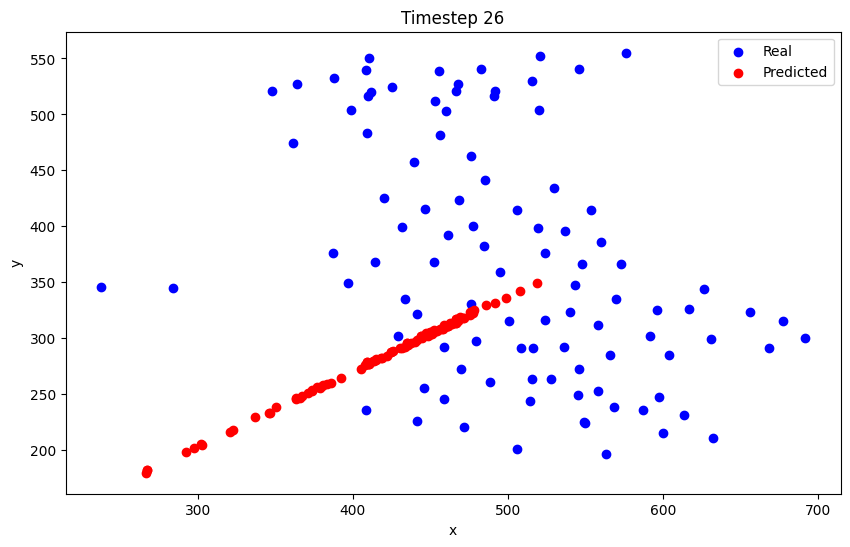

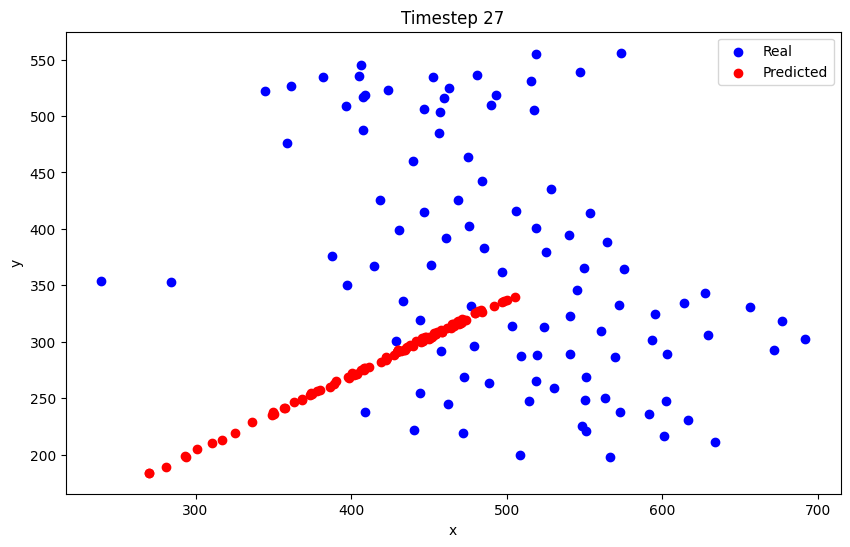

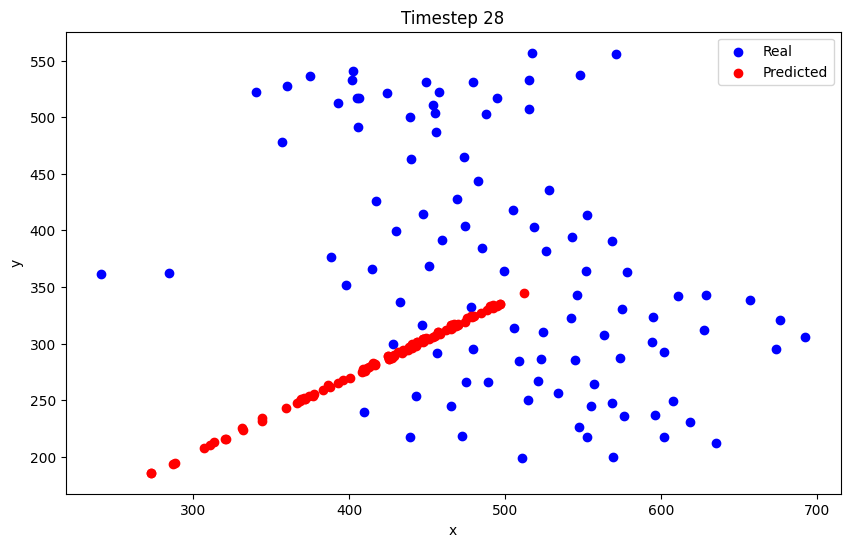

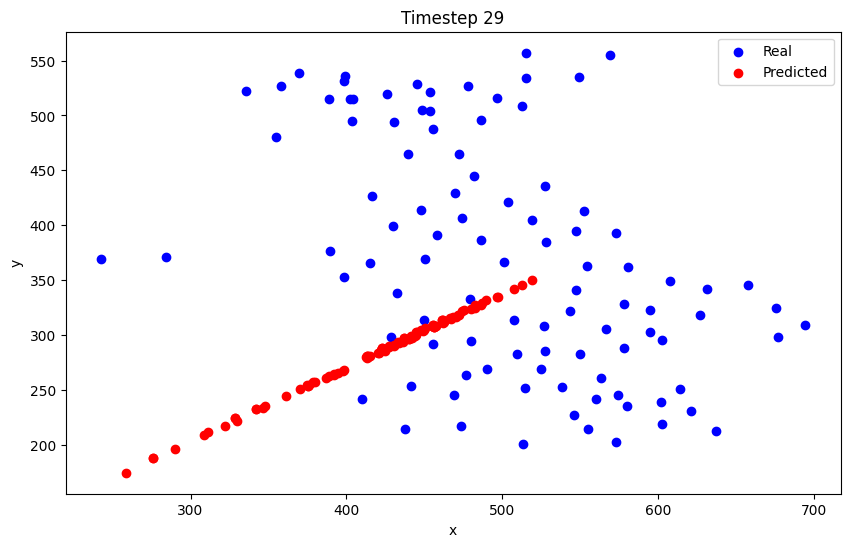

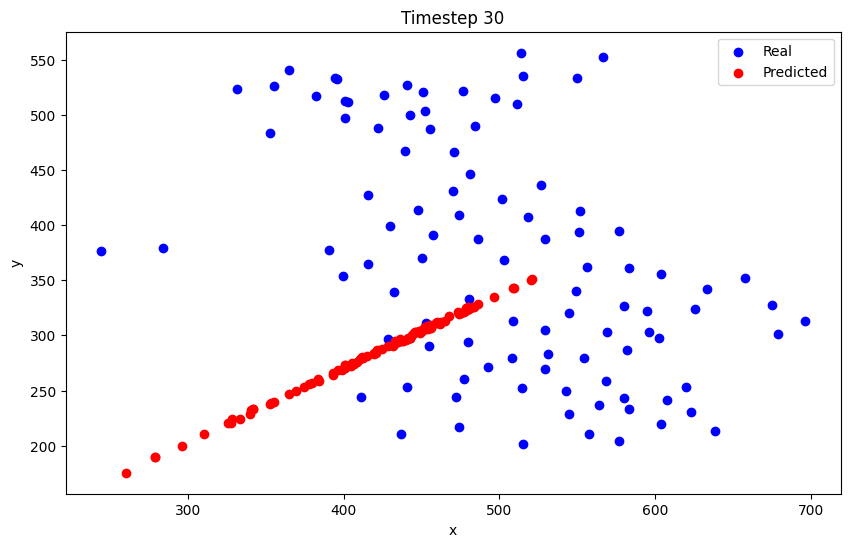

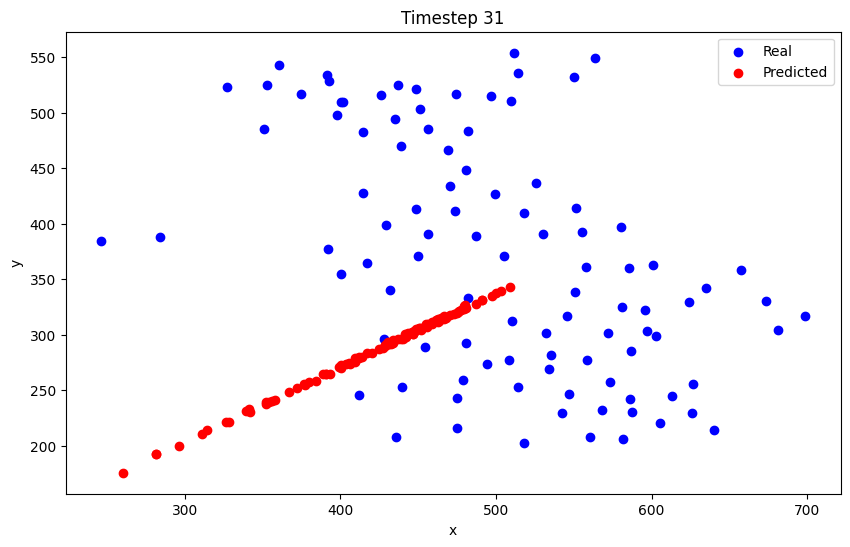

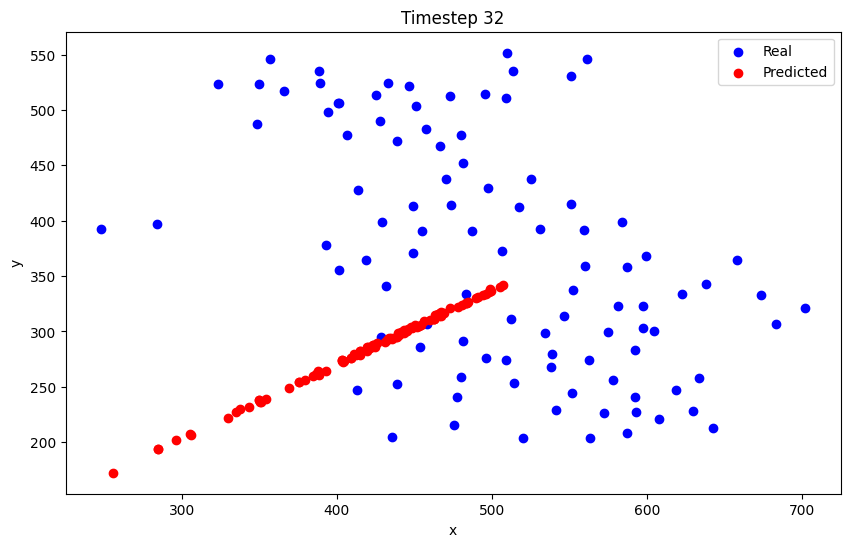

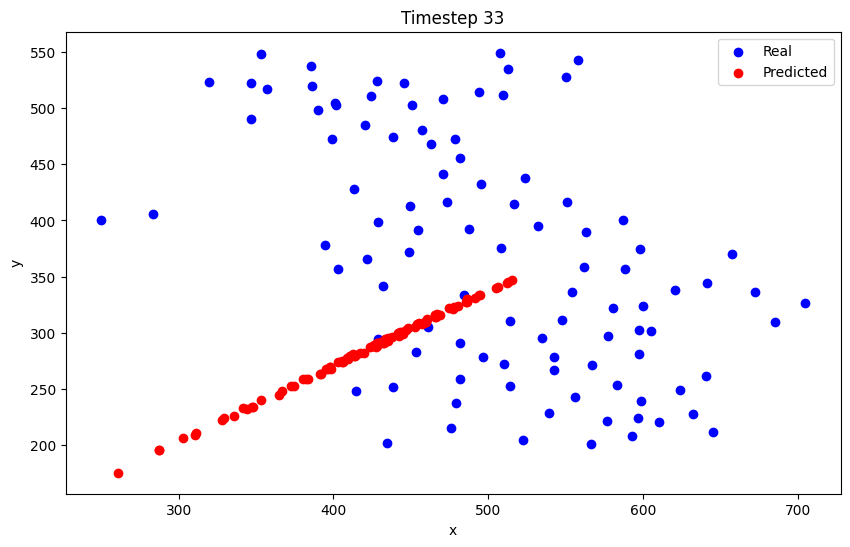

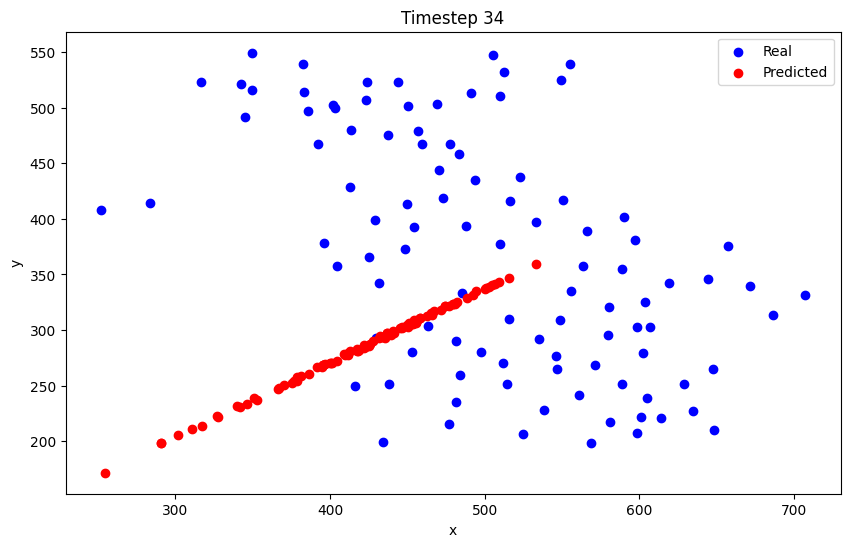

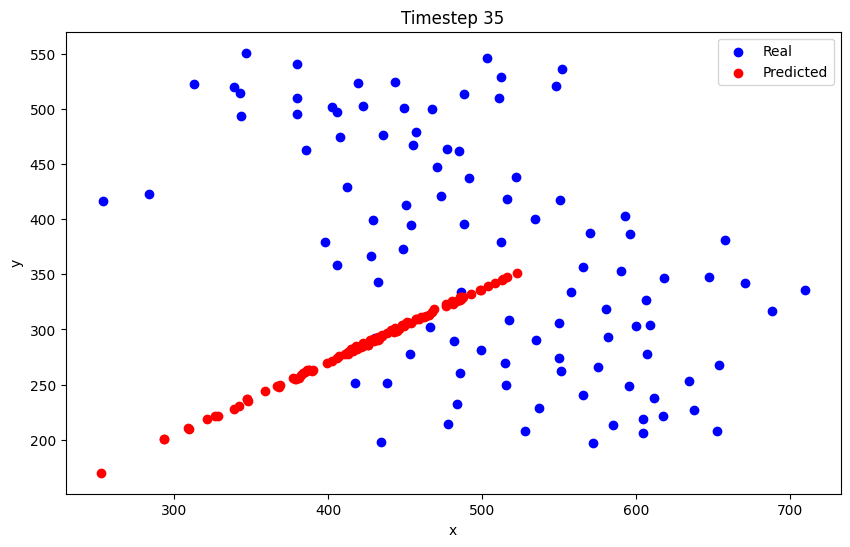

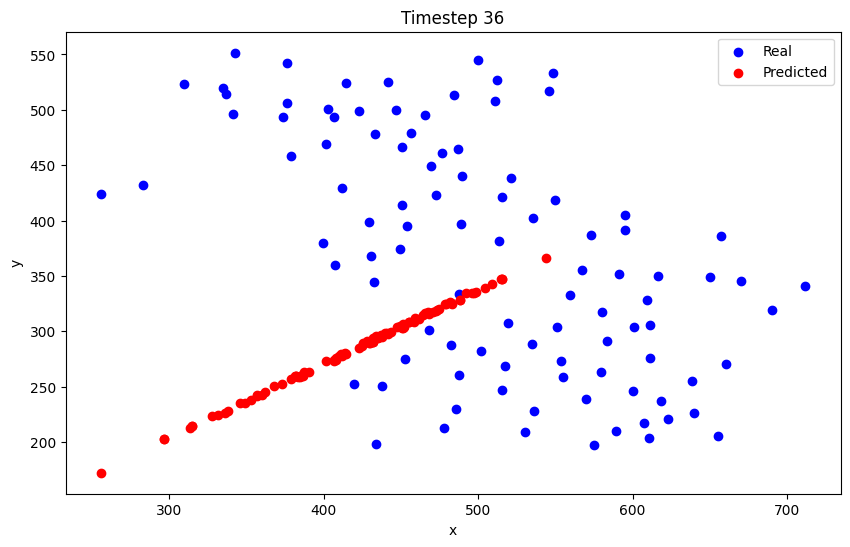

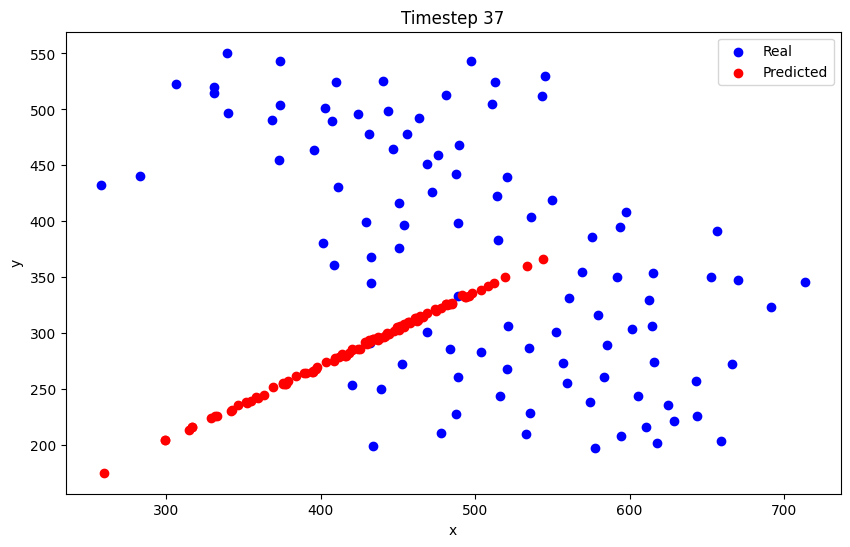

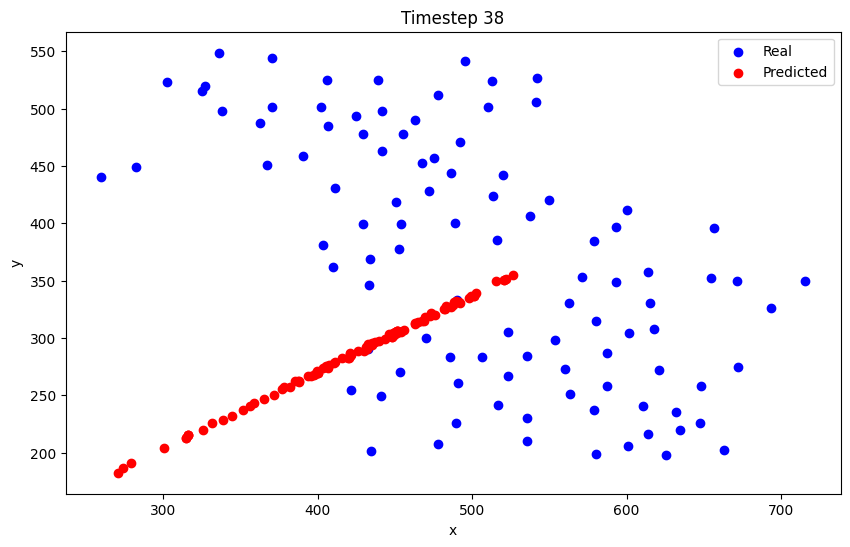

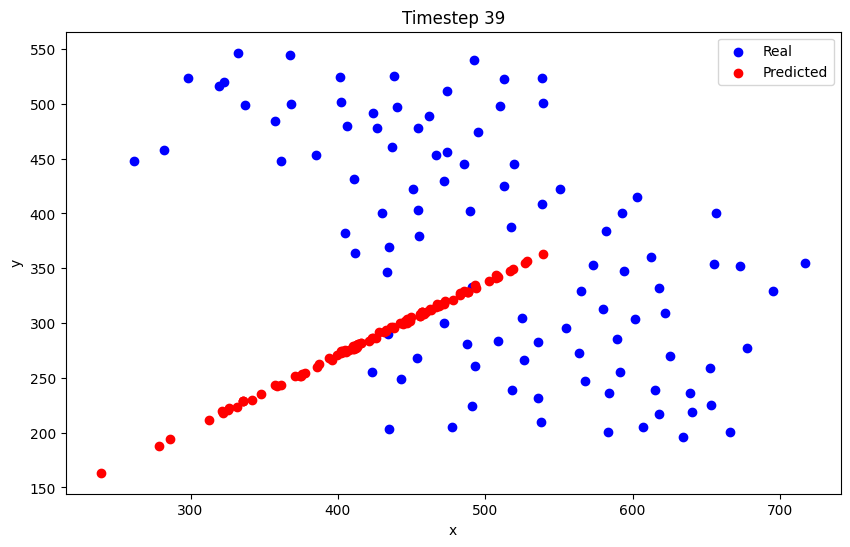

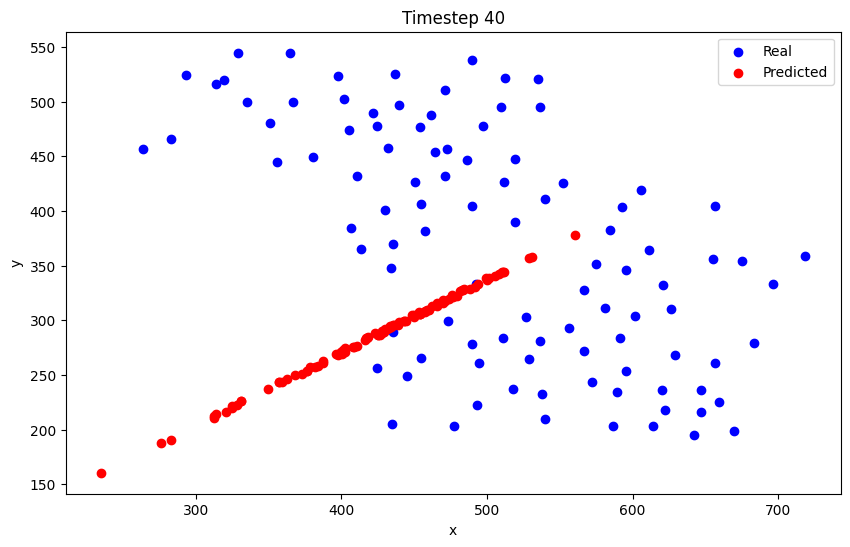

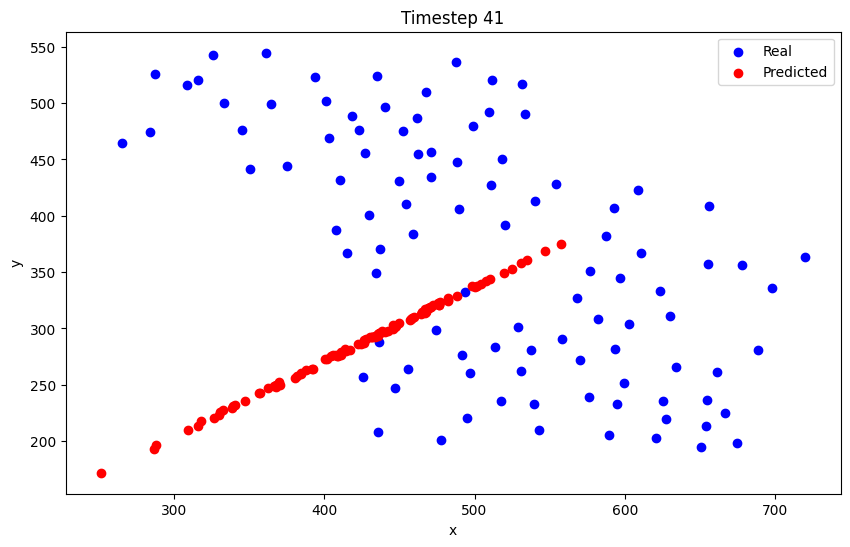

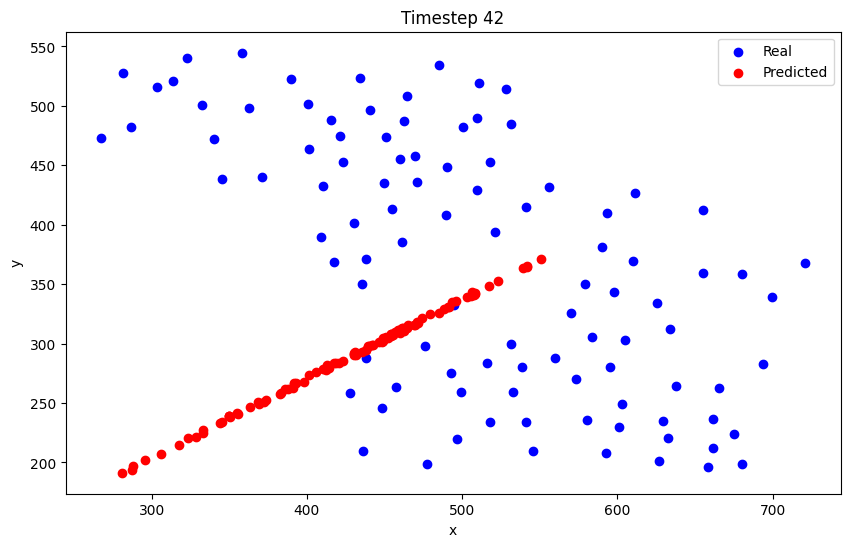

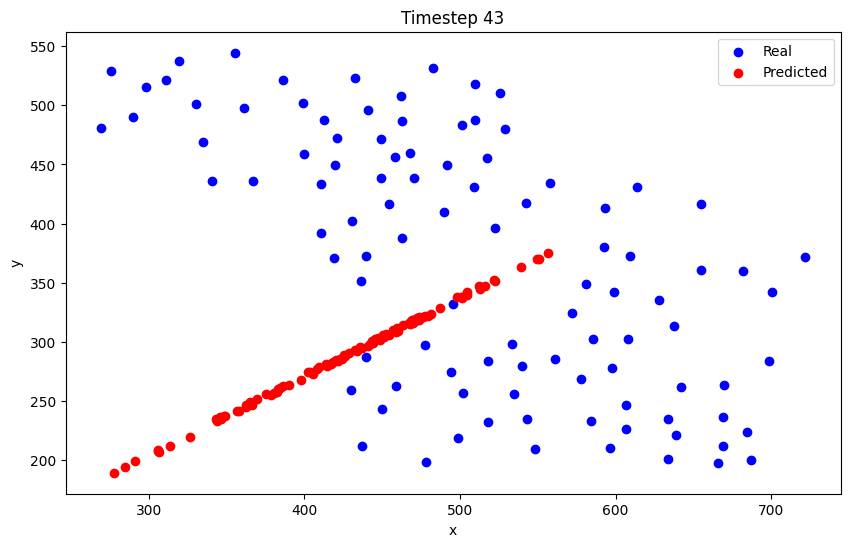

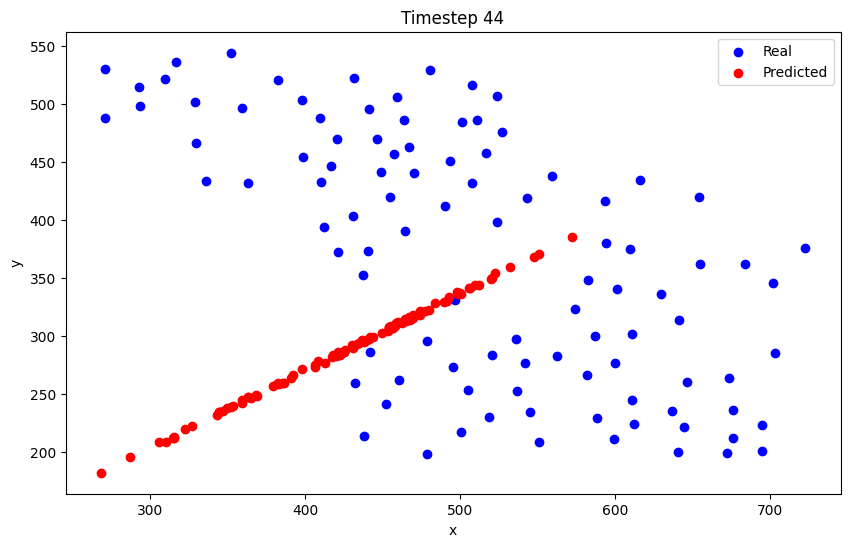

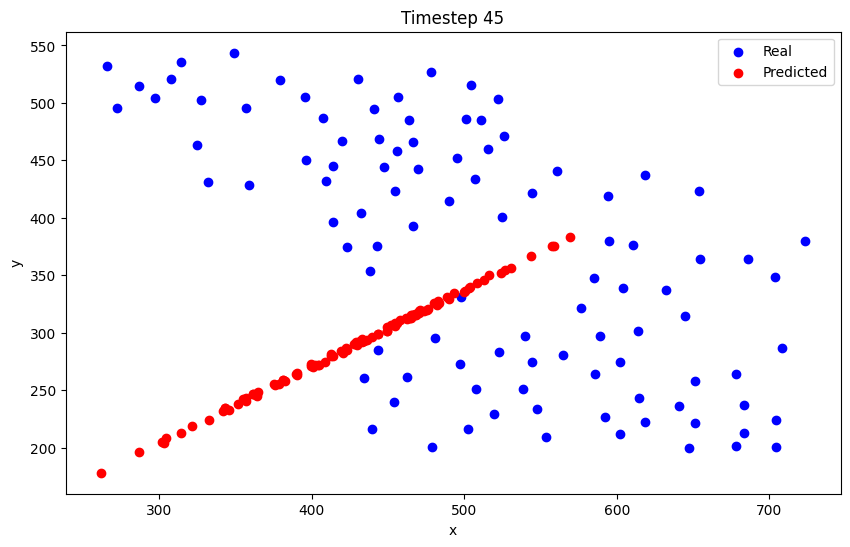

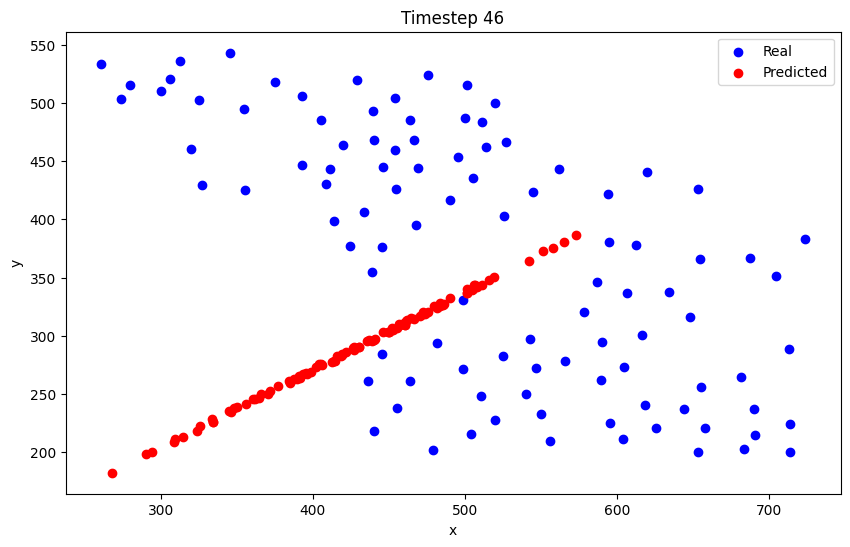

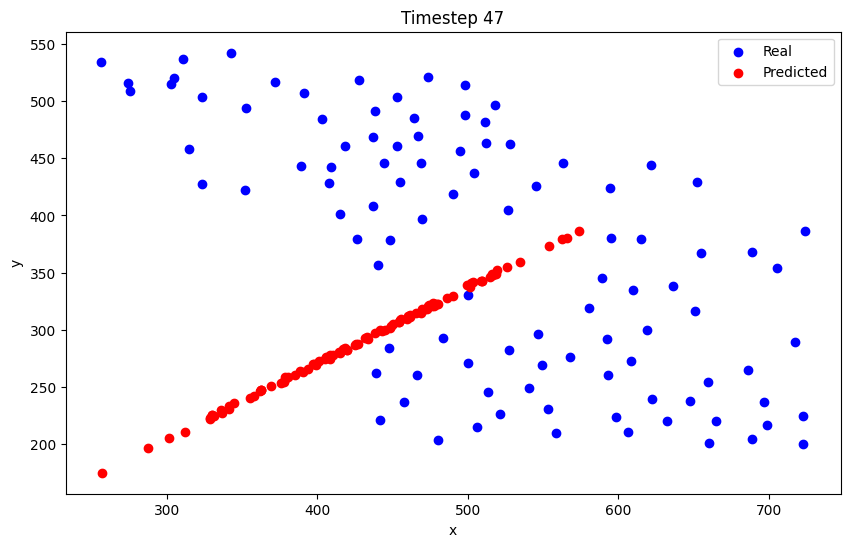

In [11]:
import math
import random
import pygame
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt
import os

# Size of canvas
width = 1000
height = 750
numBoids = 100
visualRange = 75
boids = []

def initBoids():
    global boids
    boids = []
    for i in range(numBoids):
        boids.append({
            'x': random.random() * width,
            'y': random.random() * height,
            'dx': random.random() * 10 - 5,
            'dy': random.random() * 10 - 5,
            'history': [],
        })

def distance(boid1, boid2):
    return math.sqrt((boid1['x'] - boid2['x'])**2 + (boid1['y'] - boid2['y'])**2)

def sizeCanvas():
    global width, height
    size = (width, height)
    return pygame.display.set_mode(size)

def keepWithinBounds(boid):
    margin = 200
    turnFactor = 1
    if boid['x'] < margin:
        boid['dx'] += turnFactor
    if boid['x'] > width - margin:
        boid['dx'] -= turnFactor
    if boid['y'] < margin:
        boid['dy'] += turnFactor
    if boid['y'] > height - margin:
        boid['dy'] -= turnFactor

def flyTowardsCenter(boid):
    centeringFactor = 0.005
    centerX = 0
    centerY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            centerX += otherBoid['x']
            centerY += otherBoid['y']
            numNeighbors += 1
    if numNeighbors:
        centerX /= numNeighbors
        centerY /= numNeighbors
        boid['dx'] += (centerX - boid['x']) * centeringFactor
        boid['dy'] += (centerY - boid['y']) * centeringFactor

def avoidOthers(boid):
    minDistance = 20
    avoidFactor = 0.05
    moveX = 0
    moveY = 0
    for otherBoid in boids:
        if otherBoid != boid:
            if distance(boid, otherBoid) < minDistance:
                moveX += boid['x'] - otherBoid['x']
                moveY += boid['y'] - otherBoid['y']
    boid['dx'] += moveX * avoidFactor
    boid['dy'] += moveY * avoidFactor

def matchVelocity(boid):
    matchingFactor = 0.05
    avgDX = 0
    avgDY = 0
    numNeighbors = 0
    for otherBoid in boids:
        if distance(boid, otherBoid) < visualRange:
            avgDX += otherBoid['dx']
            avgDY += otherBoid['dy']
            numNeighbors += 1
    if numNeighbors:
        avgDX /= numNeighbors
        avgDY /= numNeighbors
        boid['dx'] += (avgDX - boid['dx']) * matchingFactor
        boid['dy'] += (avgDY - boid['dy']) * matchingFactor

def limitSpeed(boid):
    speedLimit = 15
    speed = math.sqrt(boid['dx']**2 + boid['dy']**2)
    if speed > speedLimit:
        boid['dx'] = (boid['dx'] / speed) * speedLimit
        boid['dy'] = (boid['dy'] / speed) * speedLimit

def drawBoid(screen, boid):
    angle = math.atan2(boid['dy'], boid['dx'])
    boid_surface = pygame.Surface((30, 10), pygame.SRCALPHA)
    pygame.draw.polygon(boid_surface, (85, 140, 244), [
        (0, 0), (0, 10), (-15, 5)
    ])
    rotated_boid = pygame.transform.rotate(boid_surface, math.degrees(angle))
    rotated_rect = rotated_boid.get_rect(center=(boid['x'], boid['y']))
    screen.blit(rotated_boid, rotated_rect)

    if DRAW_TRAIL:
        for point in boid['history']:
            pygame.draw.circle(screen, (85, 140, 244, 102), (int(point[0]), int(point[1])), 1)

def animationLoop():
    global boids
    for boid in boids:
        flyTowardsCenter(boid)
        avoidOthers(boid)
        matchVelocity(boid)
        limitSpeed(boid)
        keepWithinBounds(boid)

        boid['x'] += boid['dx']
        boid['y'] += boid['dy']
        boid['history'].append((boid['x'], boid['y']))
        boid['history'] = boid['history'][-50:]

    screen.fill((255, 255, 255))
    for boid in boids:
        drawBoid(screen, boid)

    pygame.display.flip()
    pygame.time.Clock().tick(60)

# Save simulation data
pygame.init()
screen = sizeCanvas()
DRAW_TRAIL = False
num_time_steps = 100
num_sims = 10

num_time_steps = 100
num_sims = 10
velocities = []
positions =[]


for k in range(num_sims): # run simulation num_sims times
    initBoids() # initialize boids with different positions, and velocities
    for _ in range(num_time_steps): # run animationLoop() for num_time_steps
        for event in pygame.event.get(): # code to quit the animation (if needed)
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
        animationLoop() # updates boids to have new positions and velocities

    time_list = []  # Ensure time_list is initialized

    for i in range(len(boids[1]["history"])):  # Go through the length of history
        boid_dict = {}  # Initialize the dictionary for the current time step
        if i == 0:
            continue
        else: 
            for j in range(len(boids)):  # Go through the number of boids for every second
                dic = {}  # Initialize the dictionary for the current boid
                dic['x'] = boids[j]['history'][i][0]
                dic['y'] = boids[j]['history'][i][1]
                dic['dx'] = boids[j]['history'][i][0] - boids[j]['history'][i-1][0]
                dic['dy'] = boids[j]['history'][i][1] - boids[j]['history'][i-1][1]

                boid_dict[f'boid{j}'] = dic

        time_list.append(boid_dict)  # Append the dictionary to the list
        # Define the directory and file path
    directory = "../data/myjson/"
    file_path = f"{directory}mydata{k}.json"

    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
    with open(f"../data/myjson/mydata{k}.json", "w") as final:
        json.dump(time_list, final)

# Load and preprocess data
def load_and_preprocess_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    num_timesteps = len(data)
    num_boids = len(data[0])

    features_list = []
    adjacency_matrices = []

    for t in range(num_timesteps):
        features = np.zeros((num_boids, 4))
        for i in range(num_boids):
            boid_data = data[t][f'boid{i}']
            features[i, 0] = boid_data['x']
            features[i, 1] = boid_data['y']
            features[i, 2] = boid_data['dx']
            features[i, 3] = boid_data['dy']
        
        adjacency_matrix = np.zeros((num_boids, num_boids))
        for i in range(num_boids):
            for j in range(num_boids):
                if i != j and distance(data[t][f'boid{i}'], data[t][f'boid{j}']) < visualRange:
                    adjacency_matrix[i, j] = 1
        
        features_list.append(torch.tensor(features, dtype=torch.float))
        adjacency_matrices.append(torch.tensor(adjacency_matrix, dtype=torch.float))
    
    return features_list, adjacency_matrices

features_list, adjacency_matrices = load_and_preprocess_data("../data/myjson/mydata1.json")

print("Features shape:", features_list[0].shape)
print("Adjacency matrix shape:", adjacency_matrices[0].shape)

# Define GRNN Generator
class GRNNGenerator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GRNNGenerator, self).__init__()
        self.encoder = GCNConv(in_channels, hidden_channels)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels)
        )
    
    def forward(self, features, edge_index):
        x = self.encoder(features, edge_index)
        x = F.relu(x)
        x = self.decoder(x)
        return x

# Initialize the generator
generator = GRNNGenerator(in_channels=4, hidden_channels=16, out_channels=4)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the discriminator
discriminator = Discriminator(input_dim=4, hidden_dim=16)

# Hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.0002

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(num_epochs):
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        next_real_features = features_list[t + 1]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()

        # Train Discriminator
        d_optimizer.zero_grad()
        
        real_labels = torch.ones(next_real_features.size(0), 1)
        fake_labels = torch.zeros(next_real_features.size(0), 1)
        
        real_output = discriminator(next_real_features)
        d_loss_real = criterion(real_output, real_labels)
        
        fake_features = generator(real_features, edge_index)
        fake_output = discriminator(fake_features.detach())
        d_loss_fake = criterion(fake_output, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        g_optimizer.zero_grad()
        
        fake_output = discriminator(fake_features)
        g_loss = criterion(fake_output, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{t+1}/{len(features_list)-1}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Plotting generator predictions
with torch.no_grad():
    for t in range(len(features_list) - 1):
        real_features = features_list[t]
        edge_index = adjacency_matrices[t].nonzero(as_tuple=False).t().contiguous()
        predicted_features = generator(real_features, edge_index).numpy()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(real_features[:, 0], real_features[:, 1], c='blue', label='Real')
        plt.scatter(predicted_features[:, 0], predicted_features[:, 1], c='red', label='Predicted')
        plt.legend()
        plt.title(f'Timestep {t}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
